In [34]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Loading Geographical Data

In [35]:

msa_shapes = gpd.read_file("/data/sg/munjkim/USPTO/nokia_intern/data/raw/tl_2023_us_cbsa.shp")
msa_shapes = msa_shapes.to_crs("EPSG:4326")  



In [6]:
# msa_shapes = msa_shapes[msa_shapes['LSAD']=='M1']

In [7]:


usjobs = pd.read_excel("../data/MSA_M2022_dl.xlsx")  # ← replace with your path



In [1]:
usjobs

NameError: name 'usjobs' is not defined

In [ ]:


usjobs = pd.read_excel("../data/MSA_M2022_dl.xlsx")  # ← replace with your path



In [8]:
len(set(usjobs['AREA_TITLE']))

396

In [9]:
msa_conus = msa_shapes[
    ~msa_shapes["NAME"].str.contains(", AK|, HI", regex=True)
]

Figure 3

# Data Loading

In [10]:
inventor_table = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/patentsview/g_inventor_disambiguated.tsv', on_bad_lines= 'skip', sep ='\t')
assignee_table = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/patentsview/g_assignee_disambiguated.tsv', on_bad_lines= 'skip', sep ='\t')



In [11]:
disruptive_tasks = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/processed/disruptive_tasks.csv', on_bad_lines= 'skip')
consolidating_tasks = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/processed/consolidating_tasks.csv', on_bad_lines= 'skip')


In [12]:
jobs = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/ONET_ALI/db_24_3_text/Occupation Data.txt', sep='\t')
jobs['SOC Code'] = jobs['O*NET-SOC Code'].str[:7]

In [13]:
occupations = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/ONET_ALI/db_24_3_text/Occupation Level Metadata.txt', sep='\t')

In [14]:
location_table = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/patentsview/g_location_disambiguated.tsv', on_bad_lines = 'skip', sep = '\t')

In [16]:
occupations_naics_sector = occupations[occupations['Item'] == 'NAICS Sector']
occupations_naics_sector['SOC Code'] = occupations_naics_sector['O*NET-SOC Code'].apply(lambda x: x[:7])
occupations_naics_sector_trust = occupations_naics_sector[occupations_naics_sector['Percent']>50]
occupations_naics_sector_trust_max = occupations_naics_sector_trust.loc[occupations_naics_sector_trust.groupby('SOC Code')['Percent'].idxmax()]

/tmp/ipykernel_790994/1837511247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupations_naics_sector['SOC Code'] = occupations_naics_sector['O*NET-SOC Code'].apply(lambda x: x[:7])


In [17]:
soc_code_to_response = dict(zip(occupations_naics_sector_trust_max ['SOC Code'], occupations_naics_sector_trust_max ['Response']))



In [18]:
disruptive_tasks['patent_id'] = disruptive_tasks['patent_id'].astype(str)
consolidating_tasks['patent_id'] = consolidating_tasks['patent_id'].astype(str)


In [19]:
tasks = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/processed/tasks_matched_with_ai_patent_keywords_alicpc.csv')
quantile_threshold = tasks['patents_cosine_similarity'].quantile(0.9)
tasks_notexposedai = tasks[tasks['patents_cosine_similarity']<quantile_threshold]
tasks_exposedai = tasks[tasks['patents_cosine_similarity']>quantile_threshold]

In [20]:
tasks['s'] = tasks['patents_cosine_similarity'].gt(tasks['patents_cosine_similarity'].quantile(0.9))

In [71]:
len(disruptive_tasks['Task ID']), len(consolidating_tasks['Task ID'])

(397, 536)

In [21]:
tasks['d'] = tasks['Task ID'].apply(lambda x: x in set(disruptive_tasks['Task ID']))

In [22]:
tasks['c'] = tasks['Task ID'].apply(lambda x: x in set(consolidating_tasks['Task ID']))

In [23]:
grouped = (
    tasks
    .groupby('O*NET-SOC Code')
    .agg(
        aii_d=('d', 'mean'),
        aii_c=('c', 'mean'),
        total_tasks=('s', 'count')
    )
    .reset_index()
)

In [24]:
jobs_aii = (
    grouped
    .merge(jobs, how='left', on='O*NET-SOC Code')
    .sort_values('O*NET-SOC Code')
)

In [25]:
job_sectors = (
    occupations[
        (occupations['Item'] == 'NAICS Sector') &
        (occupations['Percent'] != 'n/a') &
        (occupations['Percent'].astype(float) >= 50)
    ]
    .copy()
)

In [26]:
job_sectors['SOC Code'] = job_sectors['O*NET-SOC Code'].str.slice(0, 7)

In [27]:
jobs_aii

,O*NET-SOC Code,aii_d,aii_c,total_tasks,Title,Description,SOC Code
0,11-1011.00,0.0,0.000000,31,Chief Executives,Determine and formulate policies and provide o...,11-1011
1,11-1011.03,0.0,0.000000,18,Chief Sustainability Officers,"Communicate and coordinate with management, sh...",11-1011
2,11-1021.00,0.0,0.000000,17,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",11-1021
3,11-2011.00,0.0,0.000000,26,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici...",11-2011
4,11-2021.00,0.0,0.000000,20,Marketing Managers,"Plan, direct, or coordinate marketing policies...",11-2021
...,...,...,...,...,...,...,...
962,53-7072.00,0.0,0.071429,14,"Pump Operators, Except Wellhead Pumpers","Tend, control, or operate power-driven, statio...",53-7072
963,53-7073.00,0.0,0.062500,16,Wellhead Pumpers,Operate power pumps and auxiliary equipment to...,53-7073
964,53-7081.00,0.0,0.125000,16,Refuse and Recyclable Material Collectors,Collect and dump refuse or recyclable material...,53-7081
965,53-7111.00,0.0,0.000000,13,Mine Shuttle Car Operators,Operate diesel or electric-powered shuttle car...,53-7111


In [28]:


# Step 3: Merge with jobs_aii on 'SOC Code'
jobs_aii_sectors = jobs_aii.merge(
    job_sectors[['O*NET-SOC Code', 'Response', 'SOC Code']],
    on='SOC Code',
    how='left'
)


In [29]:
sector_avg_aii = (
    jobs_aii_sectors
    .groupby('Response')[['aii_d', 'aii_c']]
    .mean()
    .reset_index()
    .rename(columns={'Response': 'Sector'})
)


In [30]:
sector_avg_aii['aii_d_c'] = sector_avg_aii['aii_d'] - sector_avg_aii['aii_c']

In [36]:
sector_avg_aii.sort_values(by = 'aii_d_c')

,Sector,aii_d,aii_c,aii_d_c
10,Mining,0.006211,0.055022,-0.048811
2,"Agriculture, forestry, fishing and hunting",0.007177,0.039003,-0.031826
16,Transportation and warehousing,0.031409,0.056596,-0.025186
9,Manufacturing,0.030565,0.051942,-0.021378
4,Construction,0.017016,0.034418,-0.017402
0,Accommodation and food services,0.008263,0.023133,-0.014870
12,"Professional, Scientific and Technical Services",0.037089,0.051916,-0.014827
15,Retail trade,0.012611,0.025122,-0.012511
18,Wholesale trade,0.010000,0.022500,-0.012500
13,Public administration,0.010696,0.016086,-0.005390


In [ ]:
def cal_impact_mas_level(merged_df):
    exposed_soc_codes = merged_df["SOC Code"].dropna().unique()
    exposed_mask = usjobs["OCC_CODE"].isin(exposed_soc_codes)
    usjobs_exposed = usjobs[exposed_mask]
    
    msa_exposed_emp = usjobs_exposed.groupby("AREA_TITLE")["TOT_EMP"].sum().reset_index()
    msa_exposed_emp.columns = ["AREA_TITLE", "exposed_emp"]
    msa_total_emp = usjobs[usjobs["OCC_CODE"] == "00-0000"][["AREA_TITLE", "TOT_EMP"]]
    msa_total_emp.columns = ["AREA_TITLE", "total_emp"]
    msa_impact_df = pd.merge(msa_total_emp, msa_exposed_emp, on="AREA_TITLE", how="left")

    # Fill NaN exposed_emp with 0 (i.e., no exposed jobs found in that MSA)
    msa_impact_df["exposed_emp"] = msa_impact_df["exposed_emp"].fillna(0)

    # Calculate proportion
    msa_impact_df["exposure_ratio"] = msa_impact_df["exposed_emp"] / msa_impact_df["total_emp"]
    return msa_impact_df

In [38]:
job_sectors

,O*NET-SOC Code,Item,Response,N,Percent,Date,SOC Code
231,11-2031.00,NAICS Sector,Education services,92.0,55.4,07/2017,11-2031
379,11-3031.02,NAICS Sector,Finance and insurance,86.0,98.8,07/2014,11-3031
428,11-3051.00,NAICS Sector,Manufacturing,118.0,100.0,07/2013,11-3051
527,11-3051.02,NAICS Sector,Utilities,52.0,65.4,07/2011,11-3051
563,11-3051.03,NAICS Sector,Manufacturing,65.0,90.8,07/2016,11-3051
...,...,...,...,...,...,...,...
34517,53-7063.00,NAICS Sector,Manufacturing,116.0,94.0,07/2016,53-7063
34562,53-7064.00,NAICS Sector,Manufacturing,121.0,66.9,07/2011,53-7064
34677,53-7073.00,NAICS Sector,Mining,62.0,100.0,08/2019,53-7073
34712,53-7081.00,NAICS Sector,Administrative and support and waste managemen...,48.0,100.0,07/2012,53-7081


In [45]:
# Step 3: Merge with jobs_aii on 'SOC Code'
usjobs_sectors = usjobs.merge(
    job_sectors[['O*NET-SOC Code', 'Response', 'SOC Code']],
    left_on='OCC_CODE',
    right_on='SOC Code',
    how='left')

In [46]:
usjobs_sectors

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY,O*NET-SOC Code,Response,SOC Code
0,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,21640,27440,36820,55000,78740,NaN,NaN,NaN,NaN,NaN
1,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,37140,53760,77720,110070,158500,NaN,NaN,NaN,NaN,NaN
2,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,30720,46640,73120,108780,161030,NaN,NaN,NaN,NaN,NaN
3,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2021,Marketing Managers,...,55450,66240,92040,130680,185000,NaN,NaN,NaN,NaN,NaN
4,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2022,Sales Managers,...,45380,54090,84020,127030,159850,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161674,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,53-7062,"Laborers and Freight, Stock, and Material Move...",...,31540,33430,37310,44870,48830,NaN,NaN,53-7062.00,Manufacturing,53-7062
161675,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,53-7063,Machine Feeders and Offbearers,...,32980,36810,42890,45800,51250,NaN,NaN,53-7063.00,Manufacturing,53-7063
161676,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,53-7064,"Packers and Packagers, Hand",...,29640,30770,33430,37180,43490,NaN,NaN,53-7064.00,Manufacturing,53-7064
161677,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,53-7065,Stockers and Order Fillers,...,30340,32830,34990,40320,46900,NaN,NaN,NaN,NaN,NaN


In [47]:
# Step 1: Aggregate employment by MSA and sector
msa_sector_emp = (
    usjobs_sectors
    .dropna(subset=['Response', 'TOT_EMP'])  # Drop rows missing sector or employment
    .copy()
)

In [48]:

msa_sector_emp['TOT_EMP'] = pd.to_numeric(msa_sector_emp['TOT_EMP'], errors='coerce')
msa_sector_emp = msa_sector_emp.dropna(subset=['TOT_EMP'])

In [49]:

msa_sector_emp_grouped = (
    msa_sector_emp
    .groupby(['AREA_TITLE', 'Response'])['TOT_EMP']
    .sum()
    .reset_index()
    .rename(columns={'Response': 'Sector', 'TOT_EMP': 'w_rs'})
)


In [51]:
msa_sector_aii = msa_sector_emp_grouped.merge(sector_avg_aii, on='Sector', how='left')

In [52]:


# Step 3: Compute weighted sum and normalize by total employment per MSA
# Disruptive AII
msa_d_aii = (
    msa_sector_aii
    .groupby('AREA_TITLE')
    .apply(lambda df: (df['w_rs'] * df['aii_d']).sum() / df['w_rs'].sum())
    .reset_index(name='regional_aii_d')
)

# Consolidating AII
msa_c_aii = (
    msa_sector_aii
    .groupby('AREA_TITLE')
    .apply(lambda df: (df['w_rs'] * df['aii_c']).sum() / df['w_rs'].sum())
    .reset_index(name='regional_aii_c')
)


/tmp/ipykernel_790994/999077862.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['w_rs'] * df['aii_d']).sum() / df['w_rs'].sum())
/tmp/ipykernel_790994/999077862.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['w_rs'] * df['aii_c']).sum() / df['w_rs'].sum())


(array([1179.,  396.,  745.,  643., 1188.,  348.,  670.,  396.,    0.,
        1254.]),
 array([0.        , 0.00565959, 0.01131918, 0.01697877, 0.02263836,
        0.02829795, 0.03395754, 0.03961713, 0.04527672, 0.0509363 ,
        0.05659589]),
 <BarContainer object of 10 artists>)

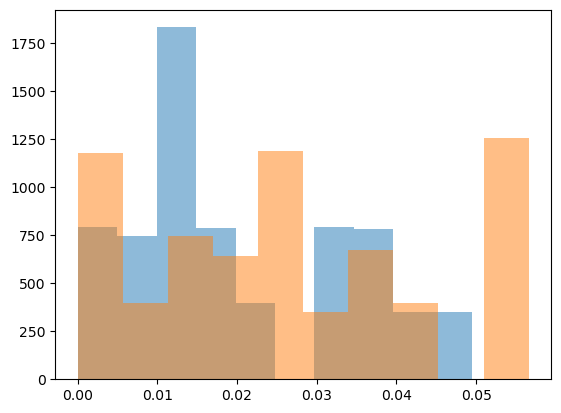

In [60]:
plt.hist(msa_sector_aii['aii_d'],alpha=0.5)
plt.hist(msa_sector_aii['aii_c'],alpha=0.5)

In [53]:

# Merge the two
regional_aii = msa_d_aii.merge(msa_c_aii, on='AREA_TITLE')
regional_aii['regional_aii_d_c'] = regional_aii['regional_aii_d'] - regional_aii['regional_aii_c']


(array([  3.,   3.,   2.,   5.,  15.,  43.,  67., 139., 101.,  18.]),
 array([-0.01618566, -0.01526699, -0.01434832, -0.01342965, -0.01251098,
        -0.01159231, -0.01067364, -0.00975497, -0.0088363 , -0.00791763,
        -0.00699896]),
 <BarContainer object of 10 artists>)

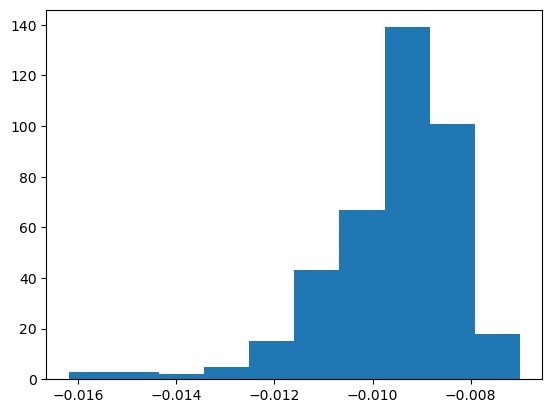

In [61]:
plt.hist(regional_aii['regional_aii_d_c'])

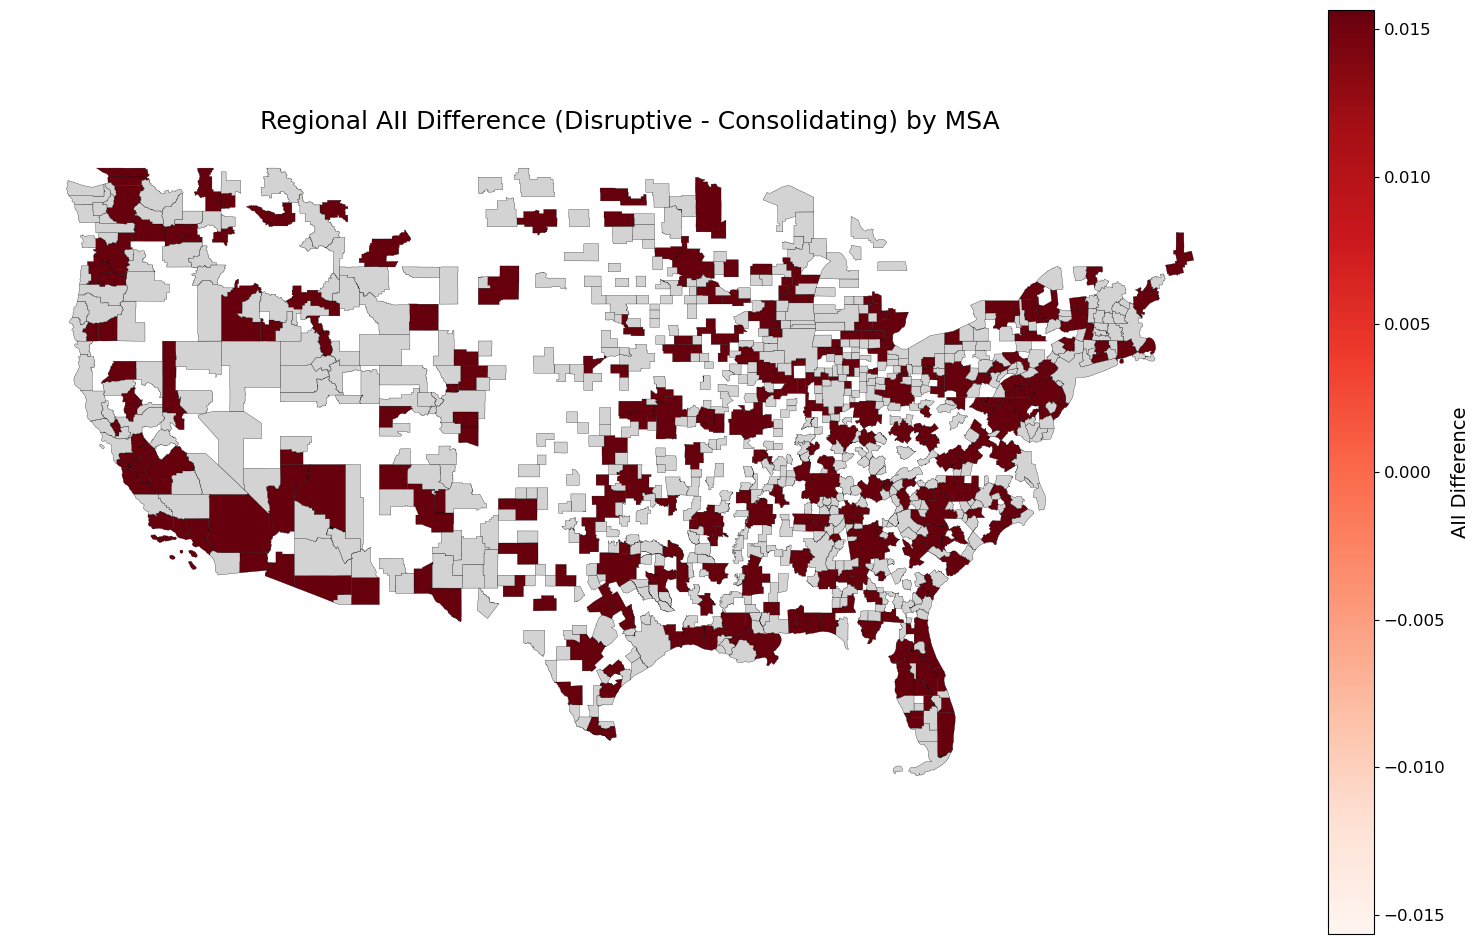

In [69]:
# Step 2: Merge with AII scores
msa_plot_df = msa_shapes.merge(regional_aii, left_on='NAME', right_on='AREA_TITLE', how='left')

# Optional: remove AK, HI, PR
msa_plot_df = msa_plot_df[~msa_plot_df['NAME'].str.contains(", AK|, HI|, PR", regex=True)]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(20, 12))

max_abs_value = np.max(np.abs(msa_plot_df['regional_aii_d_c']))
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)
msa_plot_df.plot(
    column="regional_aii_d",  # This is the difference between disruptive and consolidating
    cmap="Reds",              # Red = disruptive-dominant, Blue = consolidating-dominant
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"},
    edgecolor="black",
    linewidth=0.2,
    norm=norm
)

# Step 4: Add title, remove axis
ax.set_title("Regional AII Difference (Disruptive - Consolidating) by MSA", fontsize=18)
ax.axis("off")

# Optional: label color bar
cbar = plt.gcf().get_axes()[1]
cbar.set_ylabel("AII Difference", fontsize=14)
cbar.tick_params(labelsize=12)

plt.show()

In [72]:
msa_plot_df['regional_aii_d']

0      0.021024
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
929         NaN
930    0.021349
932         NaN
933    0.020775
934         NaN
Name: regional_aii_d, Length: 917, dtype: float64

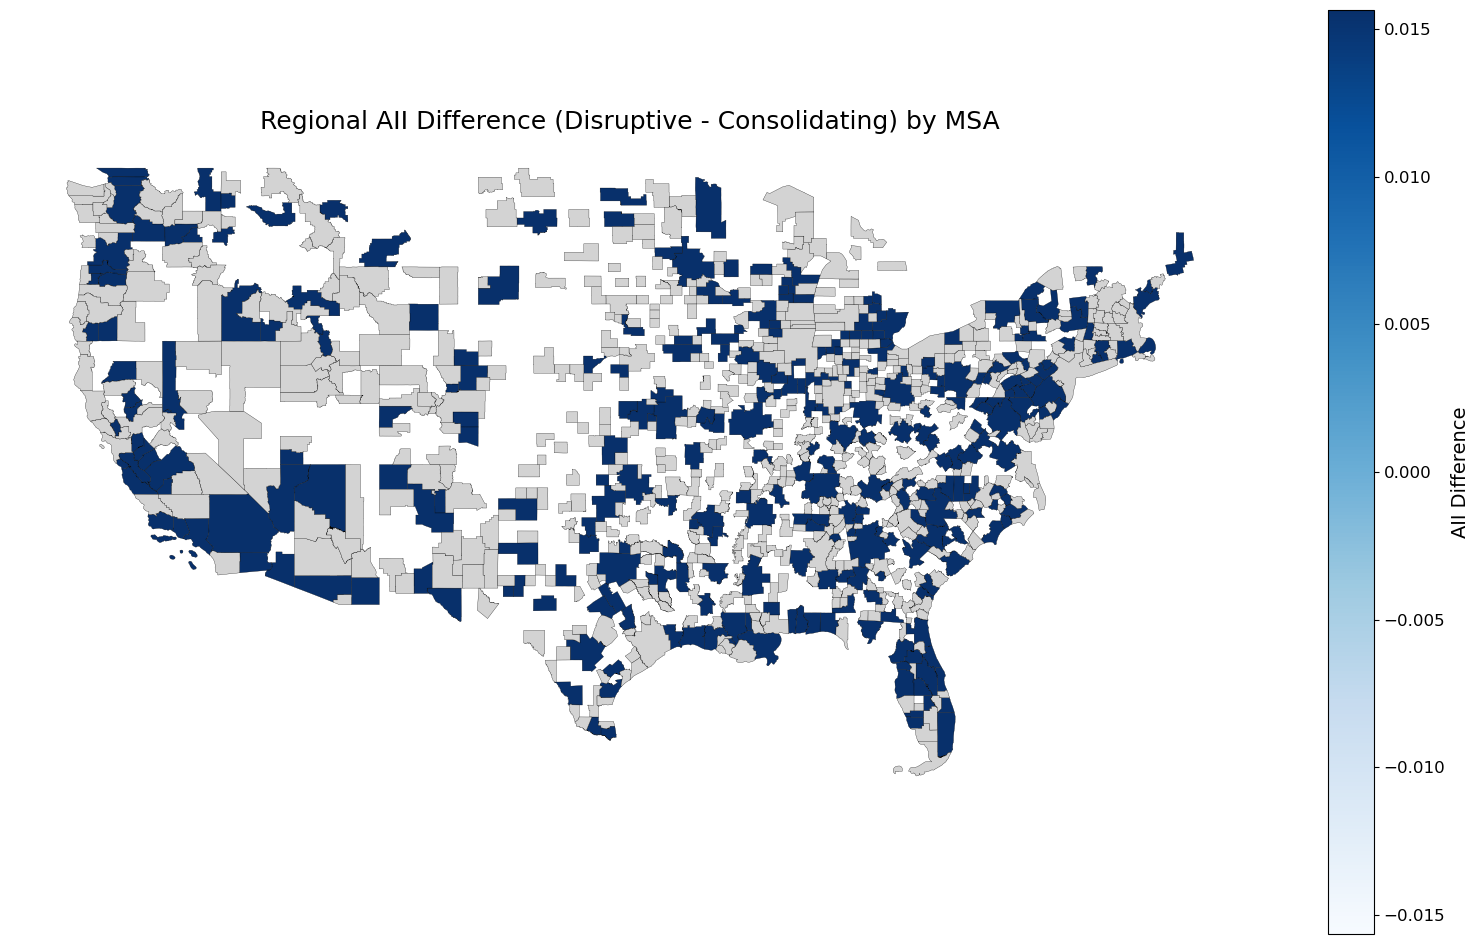

In [68]:
# Step 2: Merge with AII scores
msa_plot_df = msa_shapes.merge(regional_aii, left_on='NAME', right_on='AREA_TITLE', how='left')

# Optional: remove AK, HI, PR
msa_plot_df = msa_plot_df[~msa_plot_df['NAME'].str.contains(", AK|, HI|, PR", regex=True)]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(20, 12))

max_abs_value = np.max(np.abs(msa_plot_df['regional_aii_d_c']))
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)
msa_plot_df.plot(
    column="regional_aii_c",  # This is the difference between disruptive and consolidating
    cmap="Blues",              # Red = disruptive-dominant, Blue = consolidating-dominant
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"},
    edgecolor="black",
    linewidth=0.2,
    norm=norm
)

# Step 4: Add title, remove axis
ax.set_title("Regional AII Difference (Disruptive - Consolidating) by MSA", fontsize=18)
ax.axis("off")

# Optional: label color bar
cbar = plt.gcf().get_axes()[1]
cbar.set_ylabel("AII Difference", fontsize=14)
cbar.tick_params(labelsize=12)

plt.show()

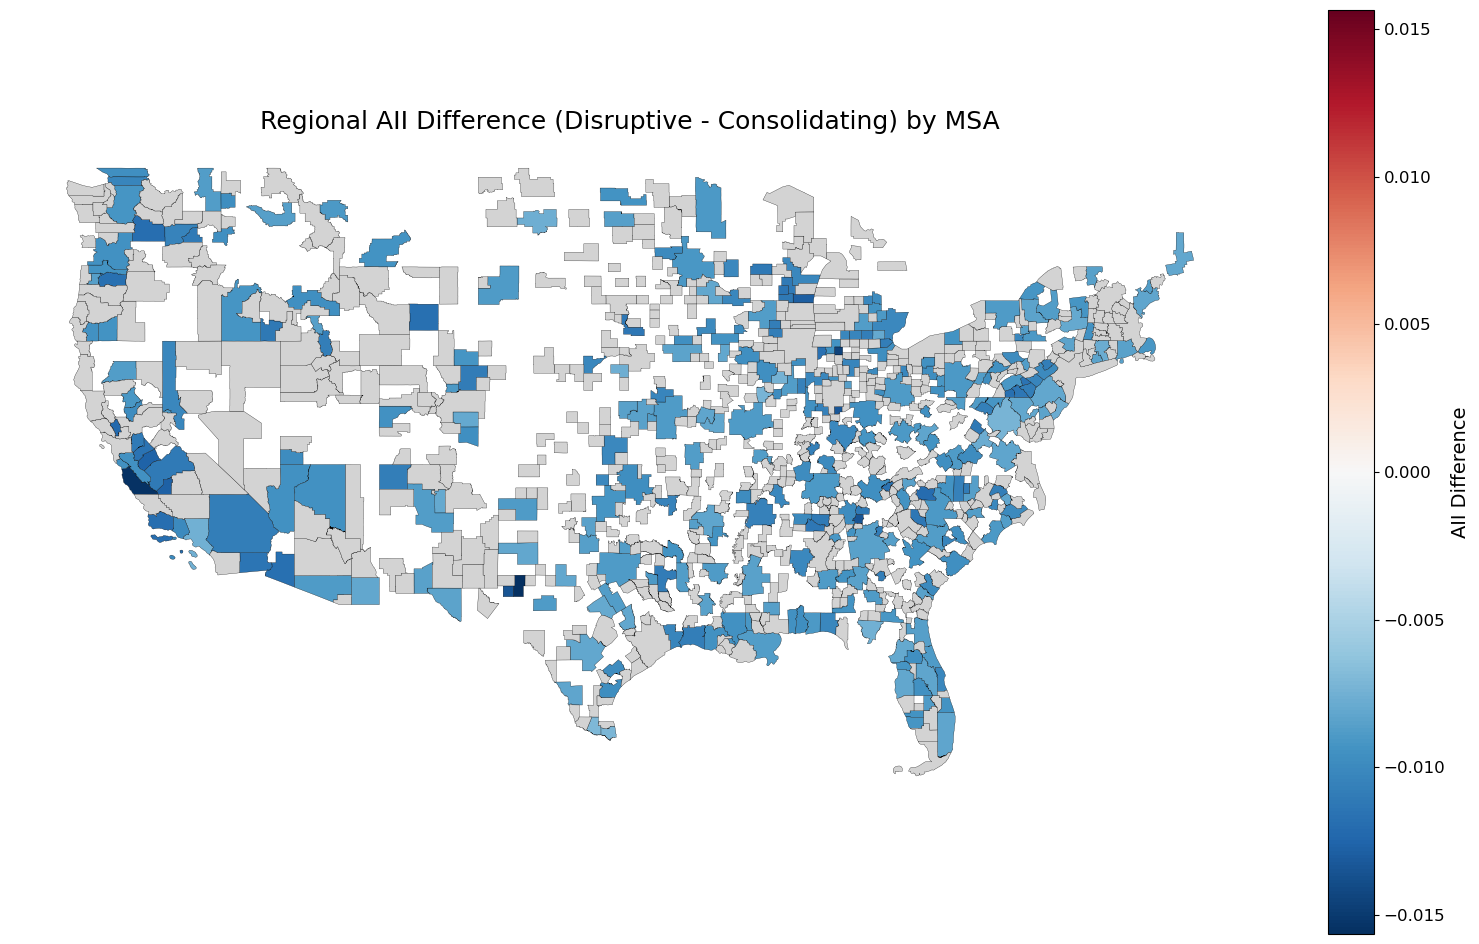

In [67]:
# Step 2: Merge with AII scores
msa_plot_df = msa_shapes.merge(regional_aii, left_on='NAME', right_on='AREA_TITLE', how='left')

# Optional: remove AK, HI, PR
msa_plot_df = msa_plot_df[~msa_plot_df['NAME'].str.contains(", AK|, HI|, PR", regex=True)]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(20, 12))

max_abs_value = np.max(np.abs(msa_plot_df['regional_aii_d_c']))
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)
msa_plot_df.plot(
    column="regional_aii_d_c",  # This is the difference between disruptive and consolidating
    cmap="RdBu_r",              # Red = disruptive-dominant, Blue = consolidating-dominant
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"},
    edgecolor="black",
    linewidth=0.2,
    norm=norm
)

# Step 4: Add title, remove axis
ax.set_title("Regional AII Difference (Disruptive - Consolidating) by MSA", fontsize=18)
ax.axis("off")

# Optional: label color bar
cbar = plt.gcf().get_axes()[1]
cbar.set_ylabel("AII Difference", fontsize=14)
cbar.tick_params(labelsize=12)

plt.show()

In [32]:
tasks_exposedai['patent_id'] =tasks_exposedai['patent_id'].astype(str)

/tmp/ipykernel_790994/2269441982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] =tasks_exposedai['patent_id'].astype(str)


In [33]:
disruptive_tasks['SOC Code'] = disruptive_tasks['O*NET-SOC Code'].apply(lambda x: x[:7])
consolidating_tasks['SOC Code'] = consolidating_tasks['O*NET-SOC Code'].apply(lambda x: x[:7])
tasks_exposedai['SOC Code'] = tasks_exposedai['O*NET-SOC Code'].apply(lambda x: x[:7])

/tmp/ipykernel_790994/2886804240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['SOC Code'] = tasks_exposedai['O*NET-SOC Code'].apply(lambda x: x[:7])


In [14]:
disruptive_merge= pd.merge(disruptive_tasks,assignee_table, on ='patent_id',how='left' )

consolidating_merge= pd.merge(consolidating_tasks,assignee_table, on ='patent_id',how='left' )
tasks_merge= pd.merge(tasks_exposedai,assignee_table, on ='patent_id',how='left' )

## combining tasks and assignee of patent

In [15]:
tasks_merged_df = pd.merge(tasks_merge, location_table, on='location_id', how='left')



disruptive_merged_df = pd.merge(disruptive_merge, location_table, on='location_id', how='left')


consolidating_merged_df = pd.merge(consolidating_merge, location_table, on='location_id', how='left')


In [196]:
len(set(disruptive_merged_df['disambig_city']))

98

In [199]:
len(set(consolidating_merged_df['disambig_city']).union(set(disruptive_merged_df['disambig_city'])))

162

In [197]:
len(set(consolidating_merged_df['disambig_city']))

93

# Assignee Location

In [244]:
def return_merged_msa_fraction(task_df_temp):

    tasks_df = task_df_temp.dropna(subset=["latitude", "longitude"]) 
    geometry = [Point(xy) for xy in zip(tasks_df["longitude"], tasks_df["latitude"])]
    tasks_gdf = gpd.GeoDataFrame(tasks_df, geometry=geometry, crs="EPSG:4326")

    
    tasks_with_msa = gpd.sjoin(tasks_gdf, msa_conus, how="left", predicate="within")
    msa_task_counts = tasks_with_msa['NAME'].value_counts().reset_index()
    msa_task_counts.columns = ['msa_name', 'patent_count']

    total_patents = msa_task_counts['patent_count'].sum()
    
    msa_task_counts['patent_fraction'] = msa_task_counts['patent_count'] / total_patents
    msa_task_counts = msa_conus.merge(msa_task_counts, left_on='NAME', right_on='msa_name', how='left')


    return msa_task_counts
    



In [245]:
us_states_merged_disruptive = return_merged_msa_fraction(disruptive_merged_df)

In [246]:
us_states_merged_consolidating = return_merged_msa_fraction(consolidating_merged_df)

In [247]:
len(set(us_states_merged_consolidating['msa_name']).union(us_states_merged_disruptive['msa_name']))

50

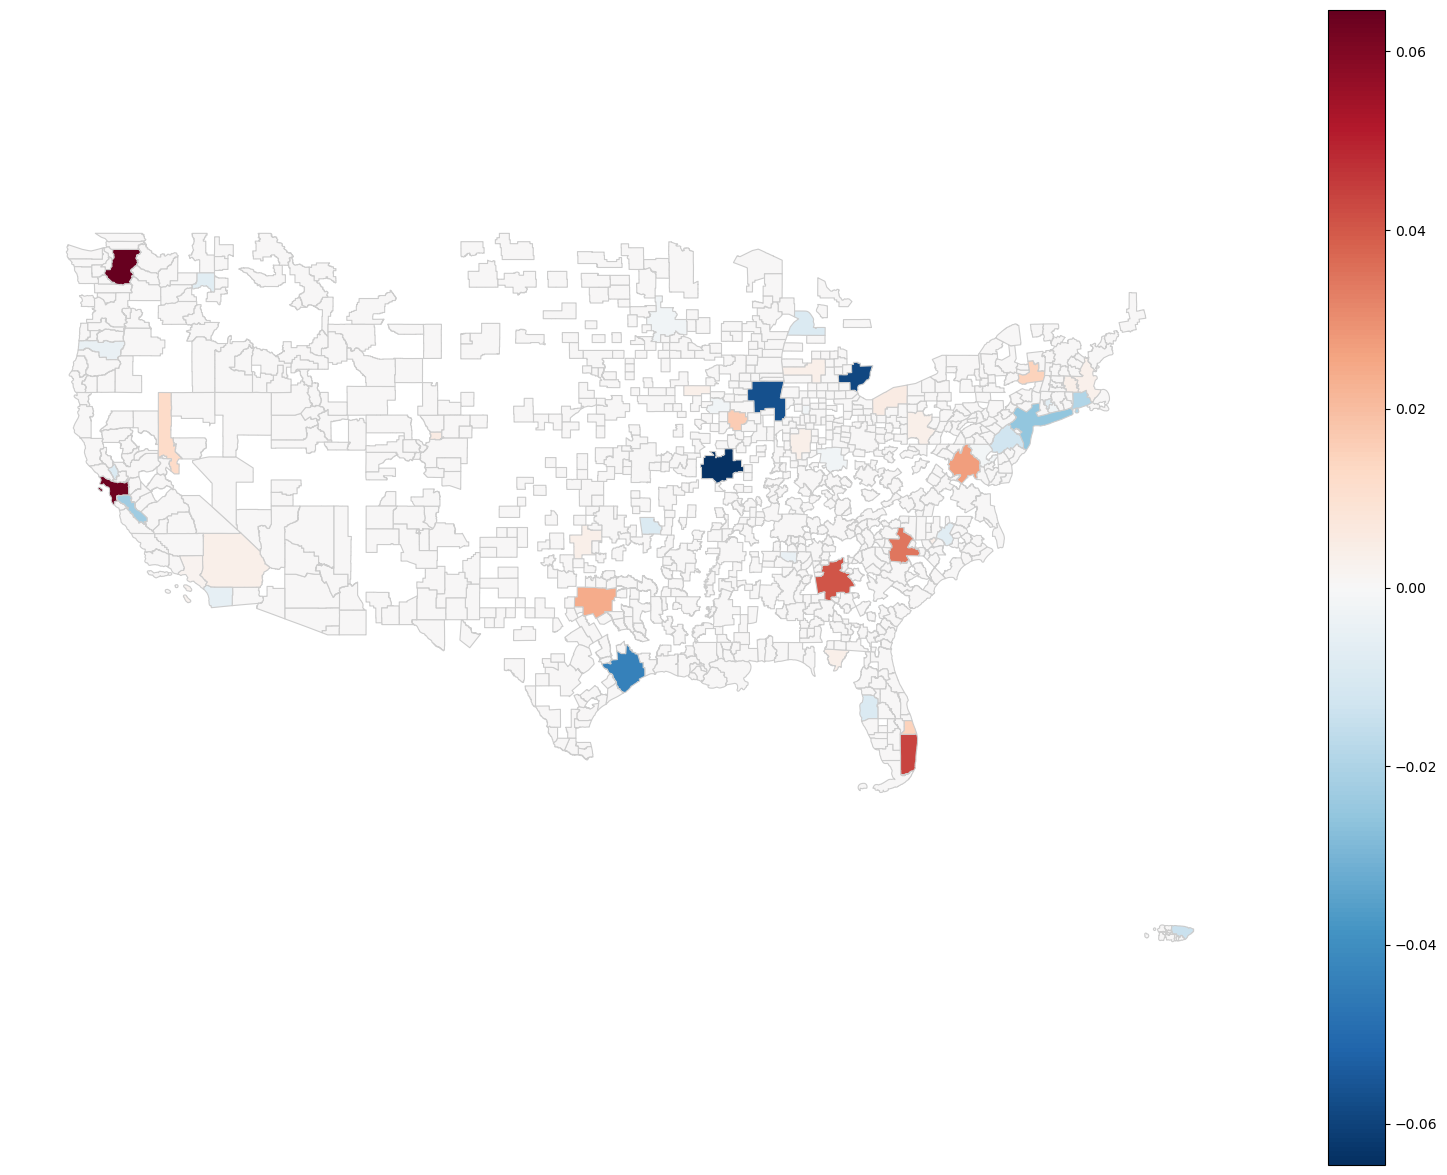

In [248]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Assuming us_states_merged and us_states_merged_disruptive are already defined

us_states_merged_consolidating['patent_fraction'] = us_states_merged_consolidating['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction'] = us_states_merged_disruptive['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] = us_states_merged_consolidating['patent_fraction'] - us_states_merged_disruptive['patent_fraction']

# Multiply by -1 to invert the sign
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] *= -1

max_abs_value = np.max(np.abs(us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating']))

# Create a diverging color map that is symmetrical around zero
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)
# Plot with reversed color map ('RdBu_r')
us_states_merged_disruptive.plot(
    column='patent_fraction_difference_disruptive_consolidating', 
    cmap='RdBu_r', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8', 
    norm=norm, 
    legend=True
)
# cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
# cbar.tick_params(labelsize=20)  # Set the font size for color bar ticks


# Remove ticks and spines
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptiveness_consolidating.png')
plt.show()



In [235]:
us_states_merged_disruptive

,CSAFP,CBSAFP,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,msa_name,patent_count,patent_fraction,patent_fraction_difference_disruptive_consolidating
0,None,34060,34060,310M700US34060,"Morgantown, WV","Morgantown, WV Metro Area",M1,1,G3110,2613054286,21658594,+39.5251551,-079.8019121,"POLYGON ((-79.76377 39.72078, -79.76272 39.720...",NaN,NaN,0.000000,-0.000000
1,294,34620,34620,310M700US34620,"Muncie, IN","Muncie, IN Metro Area",M1,1,G3110,1015558818,9841207,+40.2275433,-085.3992617,"POLYGON ((-85.57892 40.3719, -85.57892 40.3721...",NaN,NaN,0.000000,-0.000000
2,266,34740,34740,310M700US34740,"Muskegon-Norton Shores, MI","Muskegon-Norton Shores, MI Metro Area",M1,1,G3110,1305130151,2476314283,+43.4287388,-086.4209083,"POLYGON ((-85.90839 43.20592, -85.9081 43.1968...",NaN,NaN,0.000000,-0.000000
3,488,34900,34900,310M700US34900,"Napa, CA","Napa, CA Metro Area",M1,1,G3110,1947606499,104444597,+38.5070999,-122.3259045,"POLYGON ((-122.10363 38.51216, -122.10364 38.5...",NaN,NaN,0.000000,-0.009524
4,163,34940,34940,310M700US34940,"Naples-Marco Island, FL","Naples-Marco Island, FL Metro Area",M1,1,G3110,5171811319,1575210652,+26.1187860,-081.4009553,"POLYGON ((-81.62488 25.80248, -81.72296 25.801...",NaN,NaN,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,488,41940,41940,310M700US41940,"San Jose-Sunnyvale-Santa Clara, CA","San Jose-Sunnyvale-Santa Clara, CA Metro Area",M1,1,G3110,6940483804,38315150,+36.9084718,-121.3713721,"POLYGON ((-122.2026 37.36322, -122.20227 37.36...","San Jose-Sunnyvale-Santa Clara, CA",35.0,0.130597,-0.024165
385,490,41980,41980,310M700US41980,"San Juan-Bayamón-Caguas, PR","San Juan-Bayamón-Caguas, PR Metro Area",M1,1,G3110,3724996040,1457951825,+18.2944526,-066.0368437,"POLYGON ((-66.03397 18.51427, -66.03231 18.513...",NaN,NaN,0.000000,-0.014286
386,None,42220,42220,310M700US42220,"Santa Rosa-Petaluma, CA","Santa Rosa-Petaluma, CA Metro Area",M1,1,G3110,4080103614,497291856,+38.5251824,-122.9261095,"POLYGON ((-122.63507 38.58301, -122.63506 38.5...",NaN,NaN,0.000000,-0.000000
387,496,42340,42340,310M700US42340,"Savannah, GA","Savannah, GA Metro Area",M1,1,G3110,3494176650,565198504,+32.1091533,-081.2731066,"POLYGON ((-81.54801 32.48929, -81.54779 32.489...",NaN,NaN,0.000000,-0.000000


In [250]:
usjobs["TOT_EMP"] = pd.to_numeric(usjobs["TOT_EMP"], errors="coerce")
# Ensure OCC_CODE is string and trimmed to 7-digit format to match SOC Code
usjobs["OCC_CODE"] = usjobs["OCC_CODE"].astype(str).str.strip()
exposed_mask = usjobs["OCC_CODE"].isin(exposed_soc_codes)
usjobs_exposed = usjobs[exposed_mask]


In [251]:
def cal_impact_mas_level(merged_df):
    exposed_soc_codes = merged_df["SOC Code"].dropna().unique()
    exposed_mask = usjobs["OCC_CODE"].isin(exposed_soc_codes)
    usjobs_exposed = usjobs[exposed_mask]
    
    msa_exposed_emp = usjobs_exposed.groupby("AREA_TITLE")["TOT_EMP"].sum().reset_index()
    msa_exposed_emp.columns = ["AREA_TITLE", "exposed_emp"]
    msa_total_emp = usjobs[usjobs["OCC_CODE"] == "00-0000"][["AREA_TITLE", "TOT_EMP"]]
    msa_total_emp.columns = ["AREA_TITLE", "total_emp"]
    msa_impact_df = pd.merge(msa_total_emp, msa_exposed_emp, on="AREA_TITLE", how="left")

    # Fill NaN exposed_emp with 0 (i.e., no exposed jobs found in that MSA)
    msa_impact_df["exposed_emp"] = msa_impact_df["exposed_emp"].fillna(0)

    # Calculate proportion
    msa_impact_df["exposure_ratio"] = msa_impact_df["exposed_emp"] / msa_impact_df["total_emp"]
    return msa_impact_df
    



    
    
    
    

In [252]:
def cal_impact_mas_level_major_group(merged_df, usjobs):
    # Step 1: Compute major group from SOC Code
    merged_df = merged_df.copy()
    merged_df["SOC_MAJ"] = merged_df["SOC Code"].str[:2] + "-0000"
    
    # Step 2: Get unique major groups impacted
    exposed_majors = merged_df["SOC_MAJ"].dropna().unique()
    
    # Step 3: Add major group to usjobs and match
    usjobs = usjobs.copy()
    usjobs["OCC_MAJ"] = usjobs["OCC_CODE"].str[:2] + "-0000"
    
    exposed_mask = usjobs["OCC_MAJ"].isin(exposed_majors)
    usjobs_exposed = usjobs[exposed_mask]

    # Step 4: Sum exposed employment by MSA
    msa_exposed_emp = usjobs_exposed.groupby("AREA_TITLE")["TOT_EMP"].sum().reset_index()
    msa_exposed_emp.columns = ["AREA_TITLE", "exposed_emp"]

    # Step 5: Get total MSA employment (OCC_CODE == "00-0000")
    msa_total_emp = usjobs[usjobs["OCC_CODE"] == "00-0000"][["AREA_TITLE", "TOT_EMP"]]
    msa_total_emp.columns = ["AREA_TITLE", "total_emp"]

    # Step 6: Merge and calculate ratio
    msa_impact_df = pd.merge(msa_total_emp, msa_exposed_emp, on="AREA_TITLE", how="left")
    msa_impact_df["exposed_emp"] = msa_impact_df["exposed_emp"].fillna(0)
    msa_impact_df["exposure_ratio"] = msa_impact_df["exposed_emp"] / msa_impact_df["total_emp"]
    
    return msa_impact_df


In [254]:
msa_disruptive_impact_df = cal_impact_mas_level_major_group(disruptive_merged_df,usjobs)

In [255]:
msa_consolidating_impact_df = cal_impact_mas_level_major_group(consolidating_merged_df,usjobs)

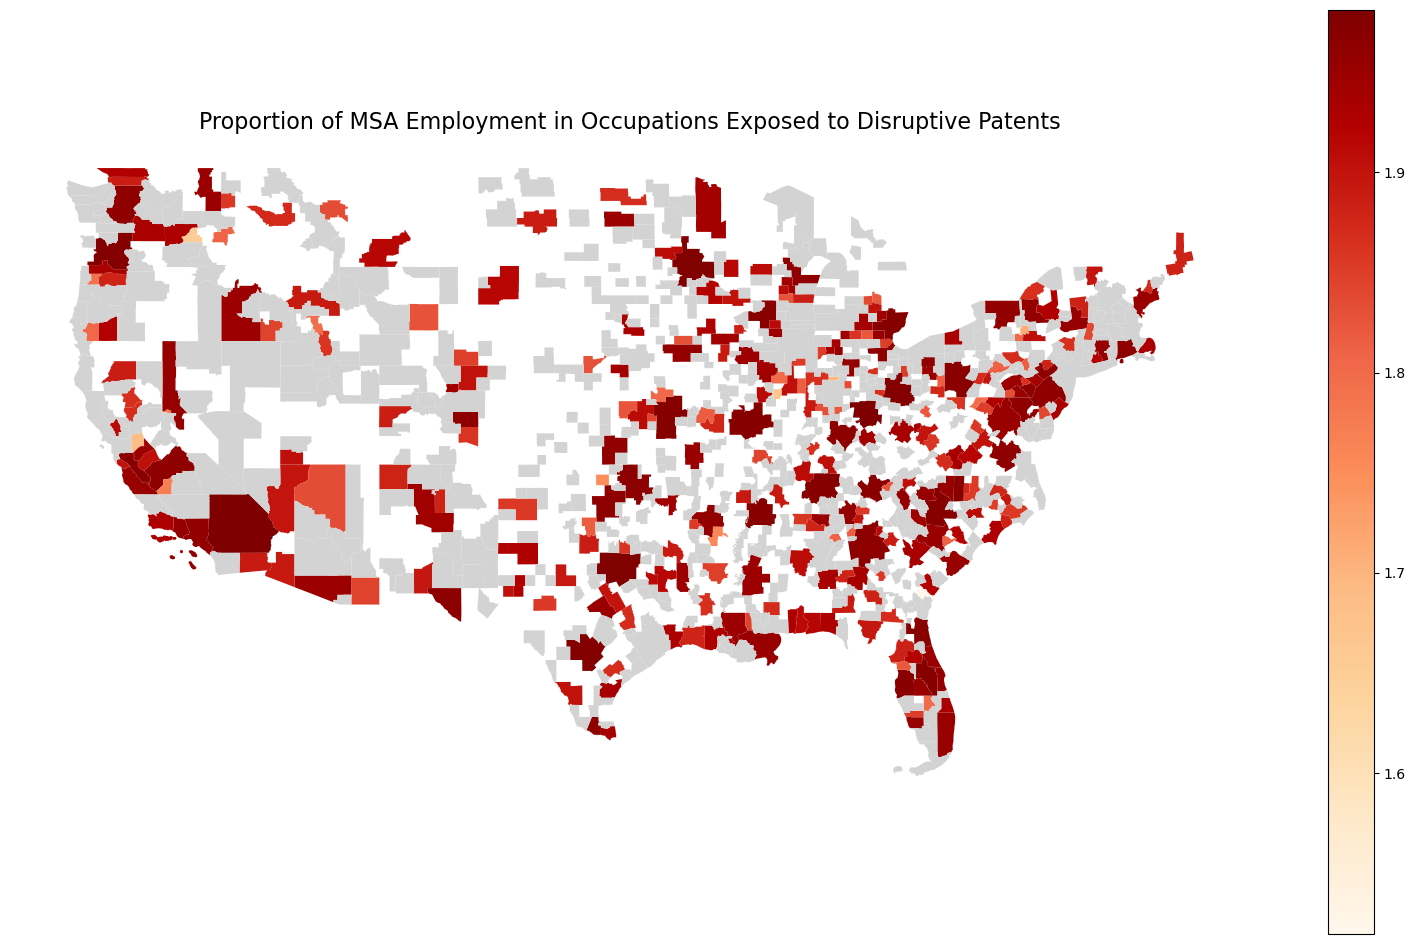

In [266]:
msa_map = msa_shapes.merge(msa_disruptive_impact_df, left_on="NAME", right_on="AREA_TITLE", how="left")
msa_map = msa_map[~msa_map["NAME"].str.contains(", AK|, HI|, PR", regex=True)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

msa_map.plot(
    column="exposure_ratio",
    cmap="OrRd",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

ax.set_title("Proportion of MSA Employment in Occupations Exposed to Disruptive Patents", fontsize=16)
ax.axis("off")
plt.show()


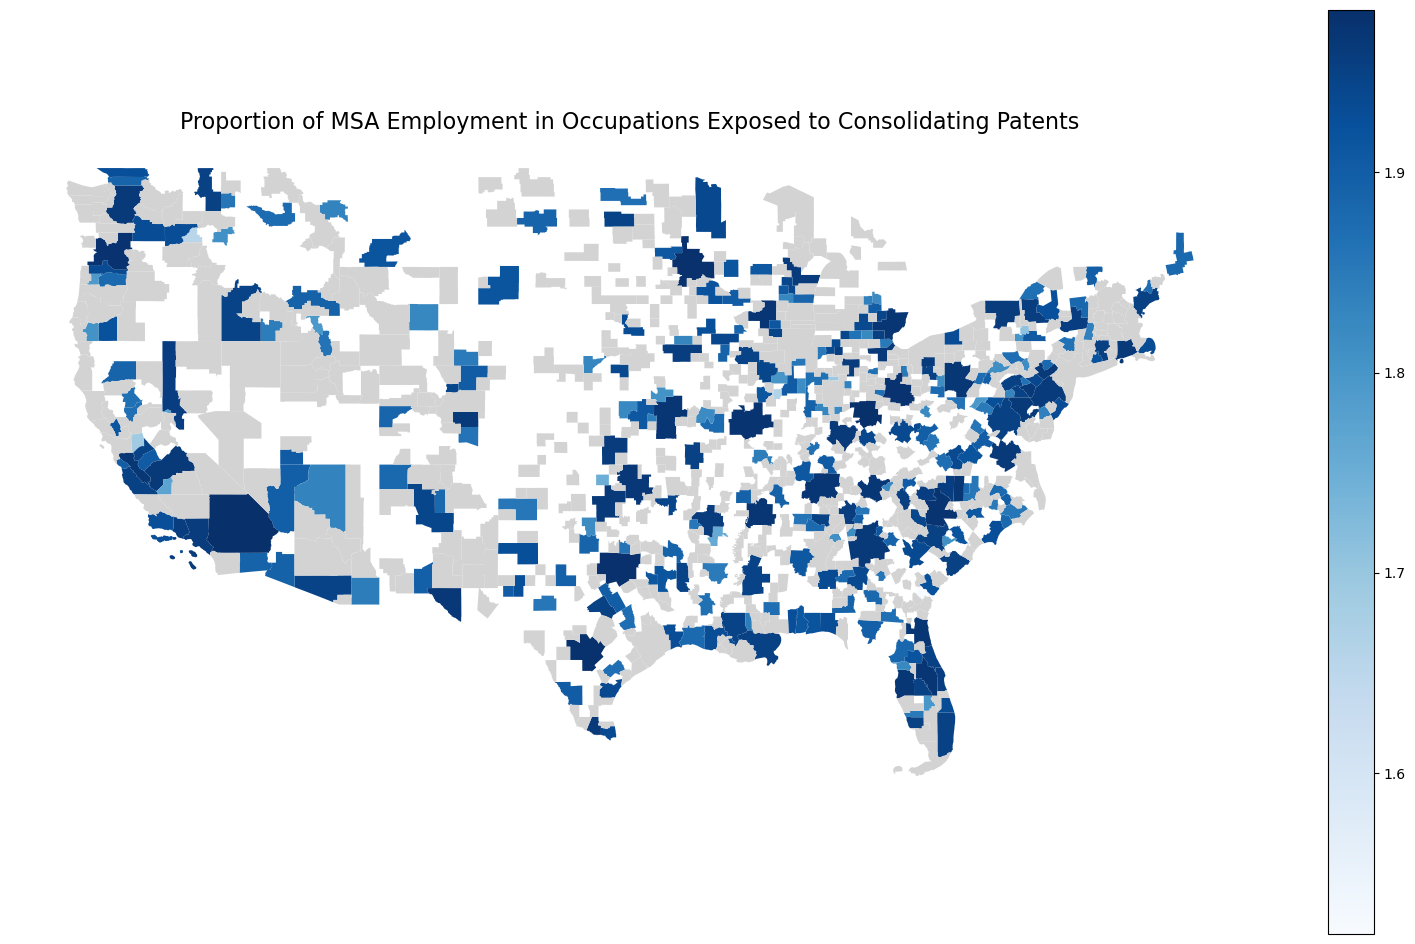

In [267]:
msa_map = msa_shapes.merge(msa_consolidating_impact_df, left_on="NAME", right_on="AREA_TITLE", how="left")
msa_map = msa_map[~msa_map["NAME"].str.contains(", AK|, HI|, PR", regex=True)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

msa_map.plot(
    column="exposure_ratio",
    cmap="Blues",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

ax.set_title("Proportion of MSA Employment in Occupations Exposed to Consolidating Patents", fontsize=16)
ax.axis("off")
plt.show()


In [268]:
msa_consolidating_impact_df['consolidating_exposure_ratio'] = msa_consolidating_impact_df['exposure_ratio']

In [269]:
msa_disruptive_impact_df['disruptive_exposure_ratio'] = msa_disruptive_impact_df['exposure_ratio']

In [270]:
msa_combined = pd.merge(
    msa_disruptive_impact_df[["AREA_TITLE", "disruptive_exposure_ratio"]],
    msa_consolidating_impact_df[["AREA_TITLE", "consolidating_exposure_ratio"]],
    on="AREA_TITLE",
    how="outer"
)


In [271]:
msa_combined = msa_combined.fillna(0)


In [272]:
msa_combined 

,AREA_TITLE,disruptive_exposure_ratio,consolidating_exposure_ratio
0,"Abilene, TX",1.893115,1.893115
1,"Aguadilla-Isabela, PR",1.872485,1.872485
2,"Akron, OH",1.960898,1.960898
3,"Albany, GA",1.880737,1.880737
4,"Albany, OR",1.879413,1.879413
...,...,...,...
391,"Yakima, WA",1.931909,1.931909
392,"York-Hanover, PA",1.950913,1.950913
393,"Youngstown-Warren-Boardman, OH-PA",1.957816,1.957816
394,"Yuba City, CA",1.868836,1.868836


In [273]:
msa_combined["exposure_difference"] = (
    msa_combined["disruptive_exposure_ratio"] - msa_combined["consolidating_exposure_ratio"]
)


In [274]:
msa_diff_map = msa_shapes.merge(msa_combined, left_on="NAME", right_on="AREA_TITLE", how="left")

# Optional: Remove AK, HI, PR
msa_diff_map = msa_diff_map[~msa_diff_map["NAME"].str.contains(", AK|, HI|, PR", regex=True)]


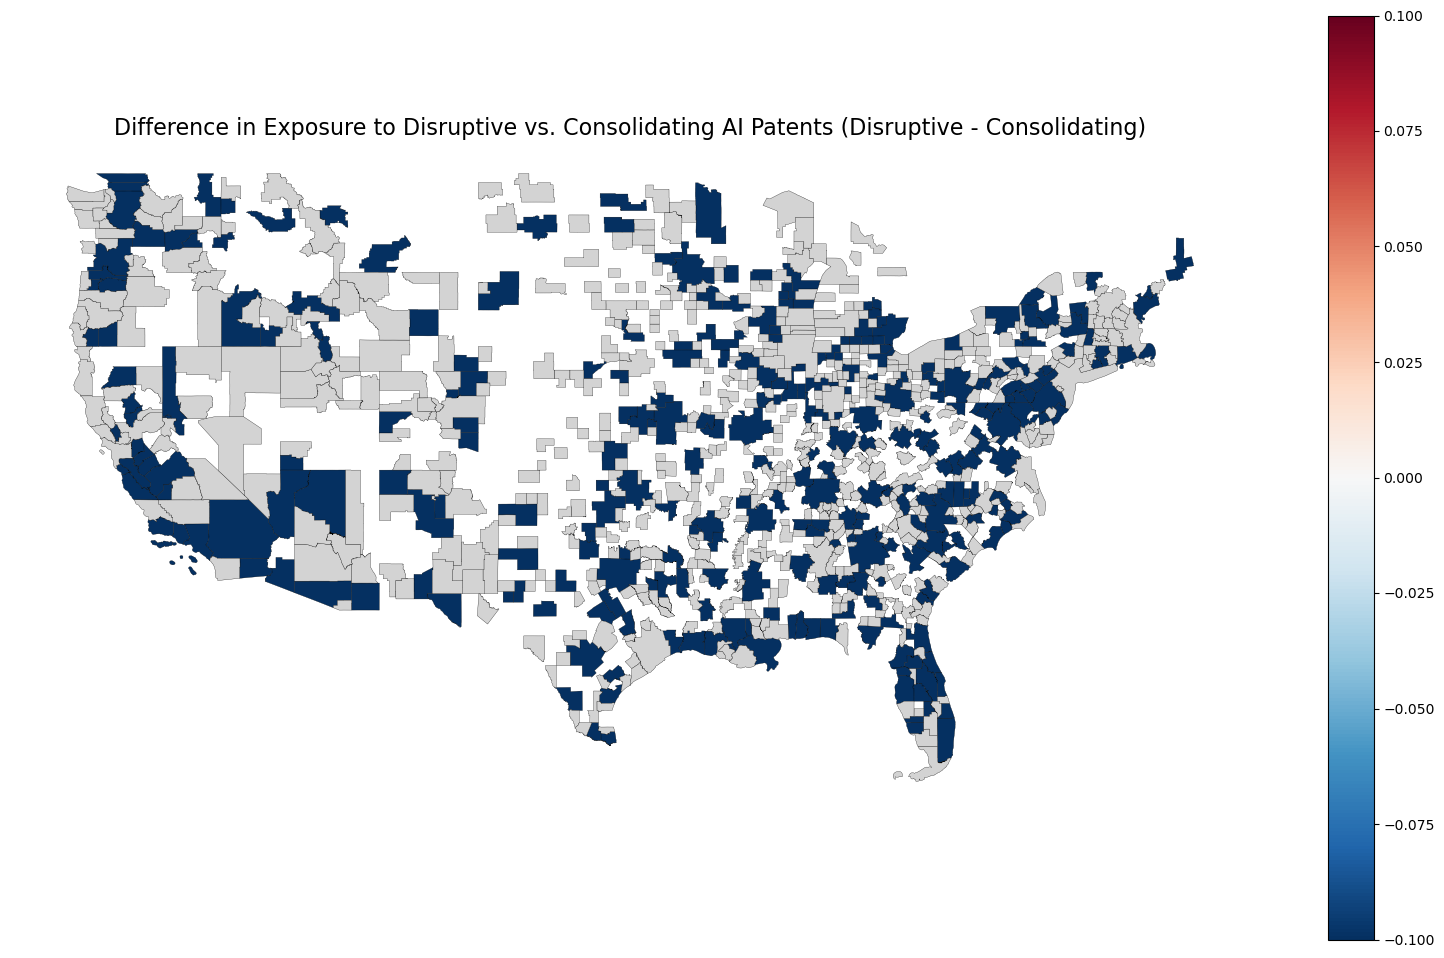

In [275]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

msa_diff_map.plot(
    column="exposure_difference",
    cmap="RdBu_r",  # Red = more disruptive, Blue = more consolidating
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"},
    edgecolor="black",
    linewidth=0.2
)

ax.set_title("Difference in Exposure to Disruptive vs. Consolidating AI Patents (Disruptive - Consolidating)", fontsize=16)
ax.axis("off")
plt.show()


In [85]:
def return_merged_msa_fraction(task_df_temp):

    tasks_df = task_df_temp.dropna(subset=["latitude", "longitude"]) 
    geometry = [Point(xy) for xy in zip(tasks_df["longitude"], tasks_df["latitude"])]
    tasks_gdf = gpd.GeoDataFrame(tasks_df, geometry=geometry, crs="EPSG:4326")

    
    tasks_with_msa = gpd.sjoin(tasks_gdf, msa_shapes, how="left", predicate="within")
    msa_task_counts = tasks_with_msa['NAME'].value_counts().reset_index()
    msa_task_counts.columns = ['msa_name', 'task_count']

    total_patents = msa_task_counts['task_count'].sum()
    
    msa_task_counts['patent_fraction'] = msa_task_counts['task_count'] / total_patents
    msa_task_counts = msa_conus.merge(msa_task_counts, left_on='NAME', right_on='msa_name', how='left')


    return msa_task_counts
    



In [86]:
us_states_merged_disruptive = return_merged_msa_fraction(disruptive_merged_df)

In [87]:
us_states_merged_consolidating = return_merged_msa_fraction(consolidating_merged_df)

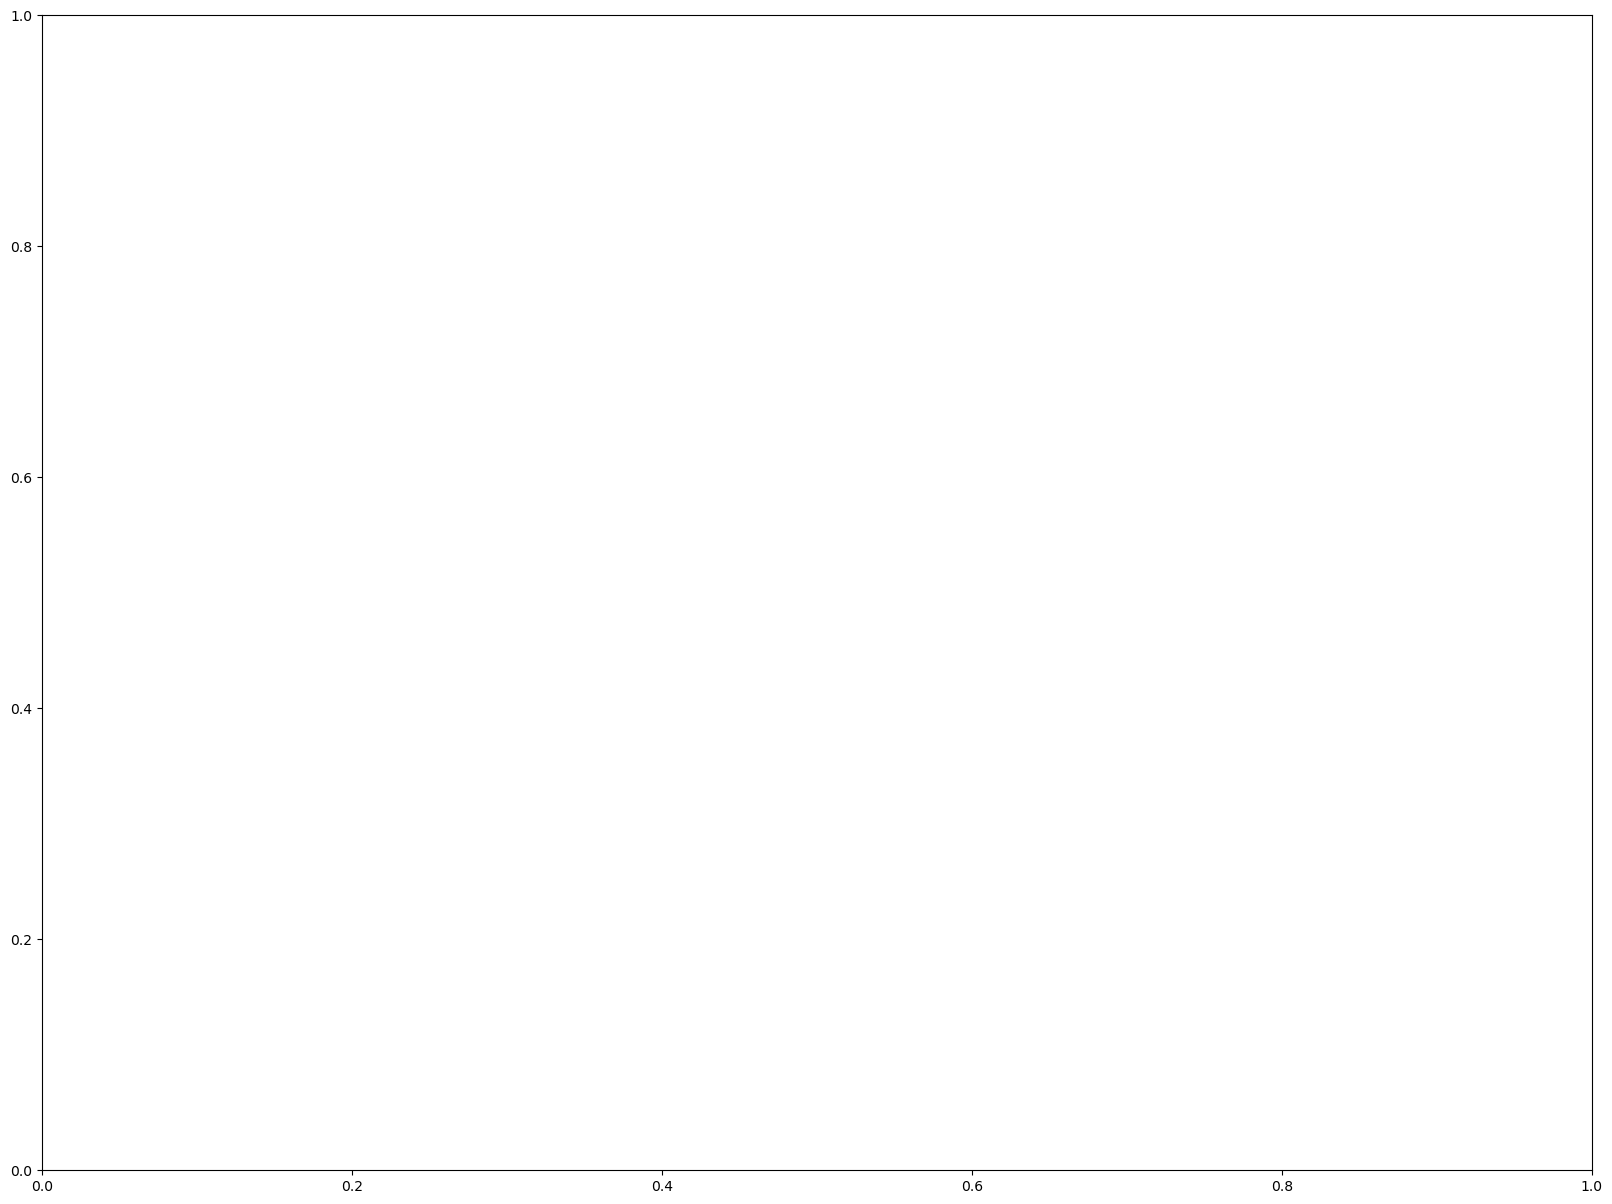

In [88]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Assuming us_states_merged and us_states_merged_disruptive are already defined

us_states_merged_consolidating['patent_fraction'] = us_states_merged_consolidating['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction'] = us_states_merged_disruptive['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] = us_states_merged_consolidating['patent_fraction'] - us_states_merged_disruptive['patent_fraction']

# Multiply by -1 to invert the sign
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] *= -1

max_abs_value = np.max(np.abs(us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating']))

# Create a diverging color map that is symmetrical around zero
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)




In [89]:
# Plot with reversed color map ('RdBu_r')
us_states_merged_disruptive.plot(
    column='patent_fraction_difference_disruptive_consolidating', 
    cmap='RdBu_r', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8', 
    norm=norm, 
    legend=True
)
# cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
# cbar.tick_params(labelsize=20)  # Set the font size for color bar ticks


# Remove ticks and spines
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptiveness_consolidating.png')
plt.show()

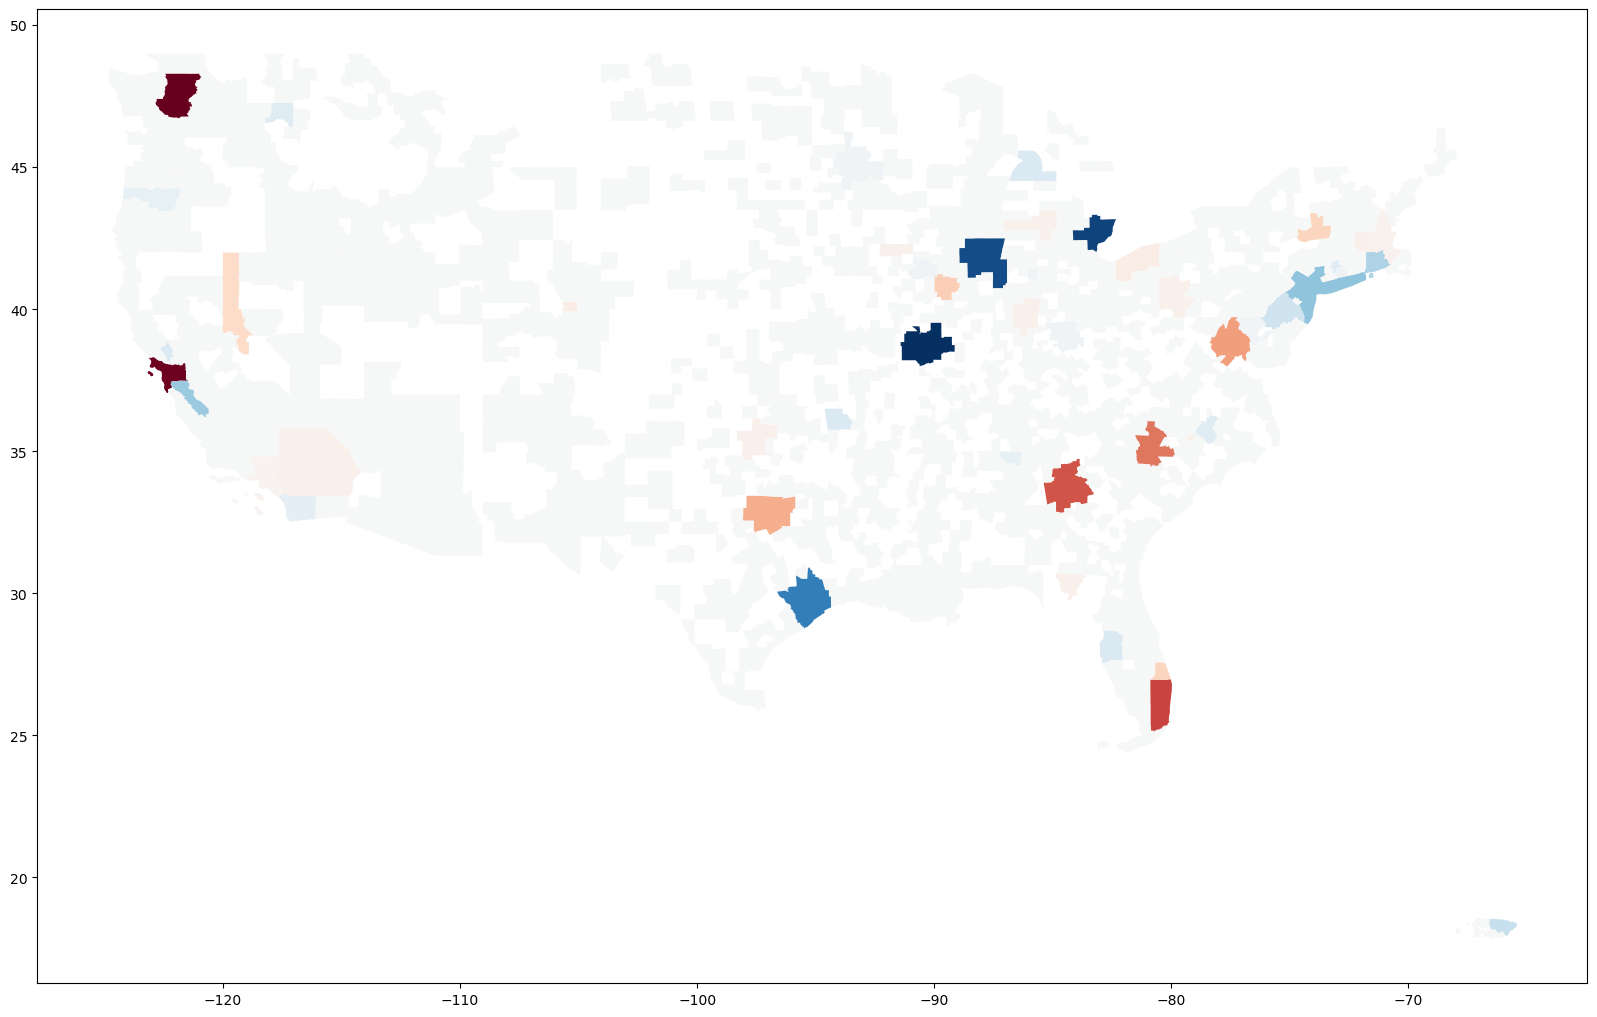

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

us_states_merged_disruptive.plot(column="patent_fraction_difference_disruptive_consolidating",
                                cmap='RdBu_r', ax=ax)
plt.show()

In [94]:
us_states_merged_disruptive

,CSAFP,CBSAFP,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,msa_name,task_count,patent_fraction,patent_fraction_difference_disruptive_consolidating
0,None,34060,34060,310M700US34060,"Morgantown, WV","Morgantown, WV Metro Area",M1,1,G3110,2613054286,21658594,+39.5251551,-079.8019121,"POLYGON ((-79.76377 39.72078, -79.76272 39.720...",NaN,NaN,0.000000,-0.000000
1,446,34140,34140,310M700US34140,"Moscow, ID","Moscow, ID Micro Area",M2,2,G3110,2786483033,2369979,+46.8189202,-116.7309737,"POLYGON ((-116.7542 46.5423, -116.75728 46.542...",NaN,NaN,0.000000,-0.000000
2,393,34180,34180,310M700US34180,"Moses Lake, WA","Moses Lake, WA Micro Area",M2,2,G3110,6939995086,289820268,+47.2136328,-119.4677880,"POLYGON ((-119.23735 46.91223, -119.23836 46.9...",NaN,NaN,0.000000,-0.000000
3,147,34300,34300,310M700US34300,"Mountain Home, ID","Mountain Home, ID Micro Area",M2,2,G3110,7964417379,68330393,+43.3946984,-115.4712050,"POLYGON ((-115.08653 43.29926, -115.08651 43.2...",NaN,NaN,0.000000,-0.000000
4,None,34500,34500,310M700US34500,"Mount Vernon, IL","Mount Vernon, IL Micro Area",M2,2,G3110,1479490501,32550293,+38.3007796,-088.9242100,"POLYGON ((-88.9308 38.12548, -88.9314 38.12548...",NaN,NaN,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,488,41940,41940,310M700US41940,"San Jose-Sunnyvale-Santa Clara, CA","San Jose-Sunnyvale-Santa Clara, CA Metro Area",M1,1,G3110,6940483804,38315150,+36.9084718,-121.3713721,"POLYGON ((-122.2026 37.36322, -122.20227 37.36...","San Jose-Sunnyvale-Santa Clara, CA",35.0,0.130112,-0.023190
923,490,41980,41980,310M700US41980,"San Juan-Bayamón-Caguas, PR","San Juan-Bayamón-Caguas, PR Metro Area",M1,1,G3110,3724996040,1457951825,+18.2944526,-066.0368437,"POLYGON ((-66.03397 18.51427, -66.03231 18.513...",NaN,NaN,0.000000,-0.014151
924,None,42220,42220,310M700US42220,"Santa Rosa-Petaluma, CA","Santa Rosa-Petaluma, CA Metro Area",M1,1,G3110,4080103614,497291856,+38.5251824,-122.9261095,"POLYGON ((-122.63507 38.58301, -122.63506 38.5...",NaN,NaN,0.000000,-0.000000
925,496,42340,42340,310M700US42340,"Savannah, GA","Savannah, GA Metro Area",M1,1,G3110,3494176650,565198504,+32.1091533,-081.2731066,"POLYGON ((-81.54801 32.48929, -81.54779 32.489...",NaN,NaN,0.000000,-0.000000


In [18]:

# Step 3: Convert tasks_df to GeoDataFrame using assignee latitude/longitude
tasks_df = tasks_merged_df.dropna(subset=["latitude", "longitude"])  # remove any nulls
geometry = [Point(xy) for xy in zip(tasks_df["longitude"], tasks_df["latitude"])]
tasks_gdf = gpd.GeoDataFrame(tasks_df, geometry=geometry, crs="EPSG:4326")



In [19]:
# Step 4: Spatial join: assign each task to a CBSA region
tasks_with_msa = gpd.sjoin(tasks_gdf, msa_shapes, how="left", predicate="within")


In [32]:
msa_task_counts = tasks_with_msa['NAME'].value_counts().reset_index()
msa_task_counts.columns = ['msa_name', 'task_count']


In [33]:
total_patents = msa_task_counts['task_count'].sum()
    
    # Convert counts to fractions of the total
msa_task_counts['task_fraction'] = msa_task_counts['task_count'] / total_patents

state_fraction_dict = msa_task_counts.set_index('msa_name')['task_fraction'].to_dict()
    

In [ ]:


geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'], disruptive_merged_df['latitude'])]
gdf_disruptive = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Assuming us_states_merged and us_states_merged_disruptive are already defined

us_states_merged['patent_fraction'] = us_states_merged['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction'] = us_states_merged_disruptive['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] = us_states_merged['patent_fraction'] - us_states_merged_disruptive['patent_fraction']

# Multiply by -1 to invert the sign
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] *= -1

max_abs_value = np.max(np.abs(us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating']))

# Create a diverging color map that is symmetrical around zero
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

# Plot with reversed color map ('RdBu_r')
us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI', 'US-AK'})].plot(
    column='patent_fraction_difference_disruptive_consolidating', 
    cmap='RdBu_r', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8', 
    norm=norm, 
    legend=True
)
cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
cbar.tick_params(labelsize=20)  # Set the font size for color bar ticks


# Remove ticks and spines
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptiveness_consolidating.png')
plt.show()


In [78]:
geometry = [Point(xy) for xy in zip(tasks_merged_df['longitude'],tasks_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(tasks_merged_df, geometry=geometry)

In [73]:
geometry = [Point(xy) for xy in zip(msa_total_df['longitude'],msa_total_df['latitude'])]
msa_gdf = gpd.GeoDataFrame(msa_total_df, geometry=geometry)

In [74]:
gdf = gpd.sjoin(gdf, msa_gdf, how="inner")

In [80]:
import geopandas as gpd

# Ensure both are GeoDataFrames with correct CRS
gdf = gdf.set_geometry('geometry').set_crs("EPSG:4326")
msa_gdf = msa_gdf.set_geometry('geometry').set_crs("EPSG:4326")


In [81]:
from shapely.geometry import Point

msa_gdf['geometry'] = gpd.points_from_xy(msa_gdf['longitude'], msa_gdf['latitude'])
msa_gdf = gpd.GeoDataFrame(msa_gdf, geometry='geometry', crs="EPSG:4326")

In [82]:
gdf_msa_joined = gpd.sjoin_nearest(gdf, msa_gdf, how='left', distance_col='distance_to_msa')

/home/munjkim/bin/envs/llm/lib/python3.13/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [91]:
patent_counts = gdf_msa_joined['AREA_TITLE'].value_counts().reset_index()

In [92]:
patent_counts 

,AREA_TITLE,count
0,"Corpus Christi, TX",600
1,"Albany, OR",283
2,"York-Hanover, PA",155
3,"Bangor, ME",150
4,"Iowa City, IA",78
5,"Fayetteville, NC",61
6,"Hilton Head Island-Bluffton-Beaufort, SC",57
7,"Killeen-Temple, TX",55
8,"Salisbury, MD-DE",42
9,"Elizabethtown-Fort Knox, KY",36


In [101]:

# Step 3: Convert tasks_df to GeoDataFrame using assignee latitude/longitude
tasks_df = tasks_merged_df.dropna(subset=["latitude", "longitude"])  # remove any nulls
geometry = [Point(xy) for xy in zip(tasks_df["longitude"], tasks_df["latitude"])]
tasks_gdf = gpd.GeoDataFrame(tasks_df, geometry=geometry, crs="EPSG:4326")



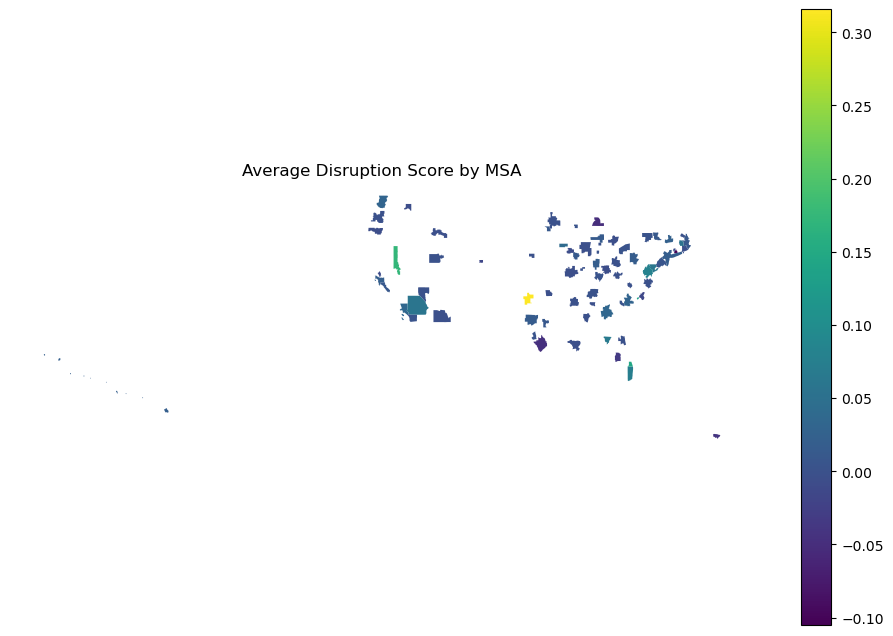

In [102]:
# Step 4: Spatial join: assign each task to a CBSA region
tasks_with_msa = gpd.sjoin(tasks_gdf, msa_shapes, how="left", predicate="within")

# Step 5: Aggregate or analyze by MSA
# For example: count number of tasks per MSA
msa_task_counts = tasks_with_msa['NAME'].value_counts().reset_index()
msa_task_counts.columns = ['msa_name', 'task_count']

# Example: average disruption score by MSA
msa_disruption_avg = tasks_with_msa.groupby("NAME")["disruption"].mean().reset_index()
msa_disruption_avg.columns = ["msa_name", "avg_disruption"]

# Merge both if needed
msa_summary = pd.merge(msa_task_counts, msa_disruption_avg, on="msa_name", how="outer")

# Optional: visualize
import matplotlib.pyplot as plt

msa_shapes = msa_shapes.merge(msa_summary, left_on="NAME", right_on="msa_name", how="left")
msa_shapes.plot(column="avg_disruption", legend=True, figsize=(12, 8))
plt.title("Average Disruption Score by MSA")
plt.axis("off")
plt.show()


In [84]:
msa_task_counts = gdf_msa_joined['AREA_TITLE'].value_counts().reset_index()
msa_task_counts.columns = ['msa_name', 'task_count']


In [85]:
msa_task_means = gdf_msa_joined.groupby('AREA_TITLE')['Data Value'].mean().reset_index()
msa_task_means.columns = ['msa_name', 'avg_data_value']


In [ ]:
# Step 4: Create GeoDataFrame
geometry = [Point(xy) for xy in zip(msa_total_df["longitude"], msa_total_df["latitude"])]
gdf = gpd.GeoDataFrame(msa_total_df, geometry=geometry, crs="EPSG:4326")

# Step 5: Count and normalize job totals per MSA
msa_counts = gdf["AREA_NAME"].value_counts().reset_index()
msa_counts.columns = ["msa", "job_count"]

# Normalize
total_jobs = msa_counts["job_count"].sum()
msa_counts["job_fraction"] = msa_counts["job_count"] / total_jobs

# Final dictionary
msa_fraction_dict = msa_counts.set_index("msa")["job_fraction"].to_dict()

# Optional: display top MSAs
print(msa_counts.head())


In [110]:
geometry = [Point(xy) for xy in zip(tasks_merged_df['longitude'],tasks_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(tasks_merged_df, geometry=geometry)
gdf = gpd.sjoin(gdf, us_states, how="inner")
    # Count patents per state
patent_counts = gdf['name'].value_counts().reset_index()
patent_counts.columns = ['state', 'patent_count']
total_patents = patent_counts['patent_count'].sum()
    
    # Convert counts to fractions of the total
patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents

state_fraction_dict = patent_counts.set_index('state')['patent_fraction'].to_dict()
    

/tmp/ipykernel_12200/1878494615.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")


In [111]:


geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'], disruptive_merged_df['latitude'])]
gdf_disruptive = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")



/tmp/ipykernel_12200/2015977970.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")


In [112]:
# Count patents per state
patent_counts_disruptive = gdf_disruptive['name'].value_counts().reset_index()
patent_counts_disruptive.columns = ['state', 'patent_count']


In [113]:
total_patents_disruptive = patent_counts_disruptive['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts_disruptive['patent_fraction'] = patent_counts_disruptive['patent_count'] / total_patents_disruptive


In [114]:
geometry = [Point(xy) for xy in zip(consolidating_merged_df['longitude'],consolidating_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(consolidating_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf = gpd.sjoin(gdf, us_states, how="inner")


/tmp/ipykernel_12200/135296190.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")


In [115]:
# Count patents per state
patent_counts = gdf['name'].value_counts().reset_index()
patent_counts.columns = ['state', 'patent_count']
total_patents = patent_counts['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents
us_states_merged = us_states.merge(patent_counts, left_on='name', right_on='state', how='left')


In [116]:
# patent_counts_disruptive['patent_fraction_difference'] = patent_counts_disruptive.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
us_states_merged_disruptive = us_states.merge(patent_counts_disruptive, left_on='name', right_on='state', how='left')


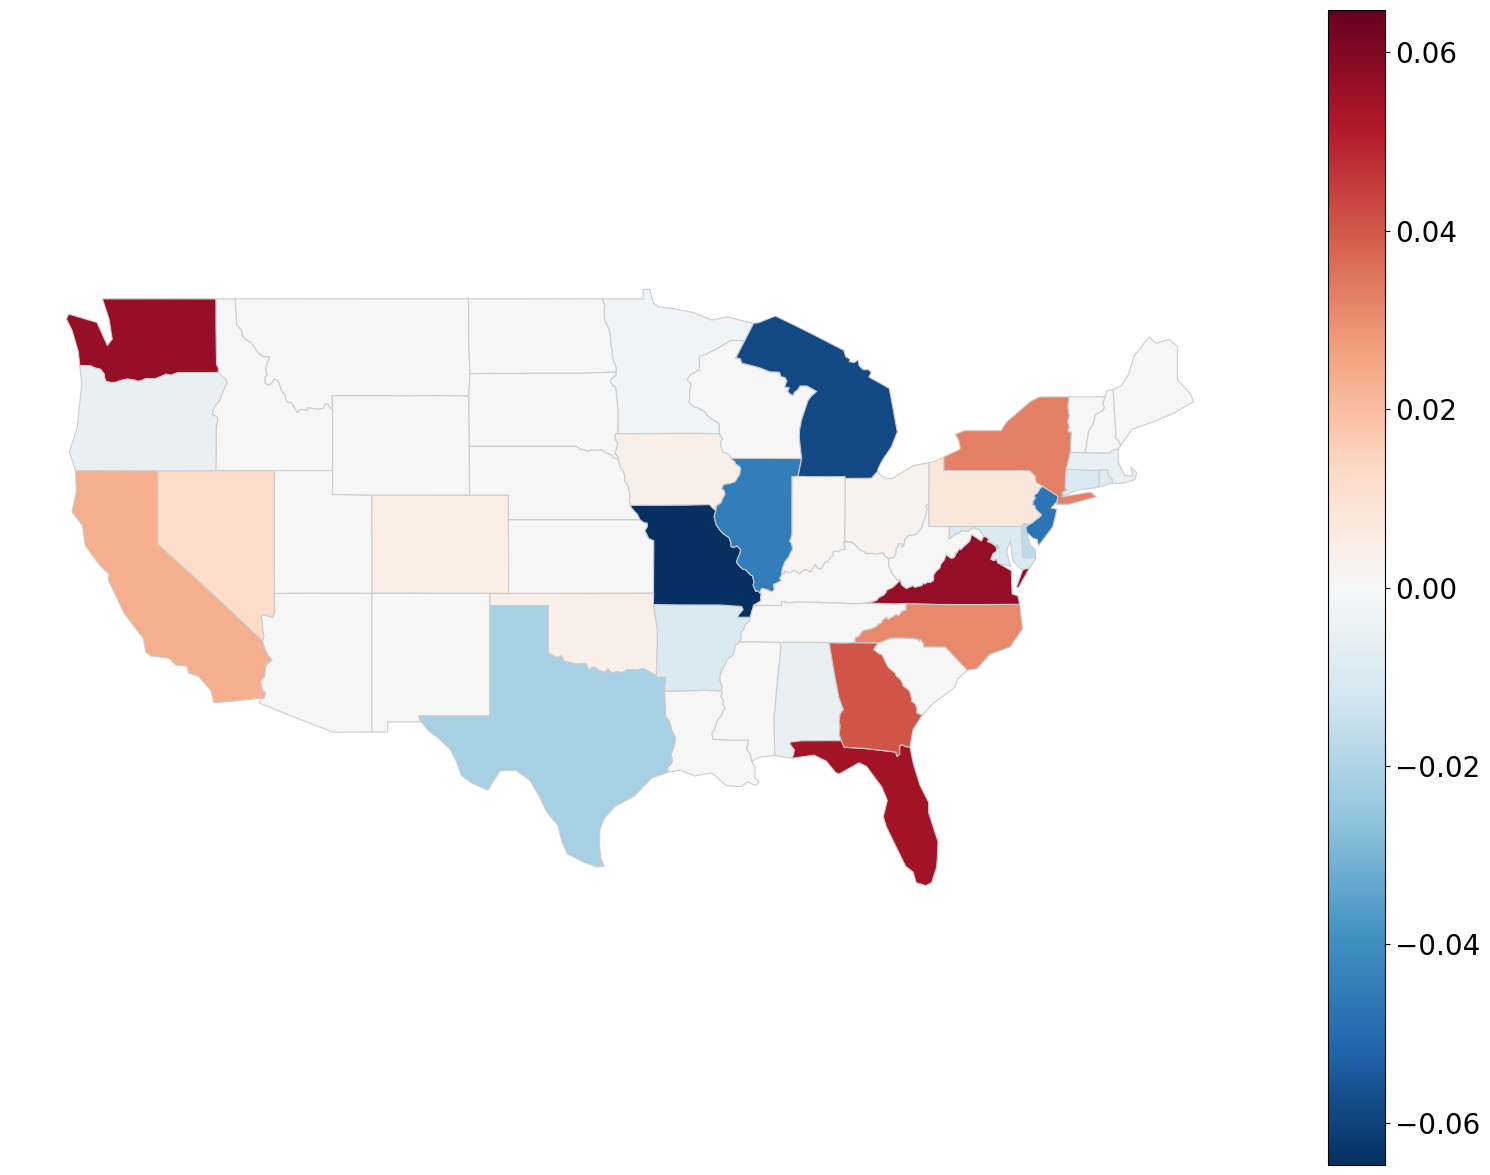

In [117]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Assuming us_states_merged and us_states_merged_disruptive are already defined

us_states_merged['patent_fraction'] = us_states_merged['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction'] = us_states_merged_disruptive['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] = us_states_merged['patent_fraction'] - us_states_merged_disruptive['patent_fraction']

# Multiply by -1 to invert the sign
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] *= -1

max_abs_value = np.max(np.abs(us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating']))

# Create a diverging color map that is symmetrical around zero
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

# Plot with reversed color map ('RdBu_r')
us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI', 'US-AK'})].plot(
    column='patent_fraction_difference_disruptive_consolidating', 
    cmap='RdBu_r', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8', 
    norm=norm, 
    legend=True
)
cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
cbar.tick_params(labelsize=20)  # Set the font size for color bar ticks


# Remove ticks and spines
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptiveness_consolidating.png')
plt.show()


In [118]:
us_states = gpd.read_file('../data/raw/naturalearth_lowers/')
geometry = [Point(xy) for xy in zip(consolidating_merged_df['longitude'],consolidating_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(consolidating_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf = gpd.sjoin(gdf, us_states, how="inner")


/tmp/ipykernel_12200/3846546571.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")


In [119]:
# Count patents per state
patent_counts = gdf['name'].value_counts().reset_index()
patent_counts.columns = ['state', 'patent_count']
total_patents = patent_counts['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents
patent_counts['patent_fraction_difference'] = patent_counts.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
us_states_merged = us_states.merge(patent_counts, left_on='name', right_on='state', how='left')


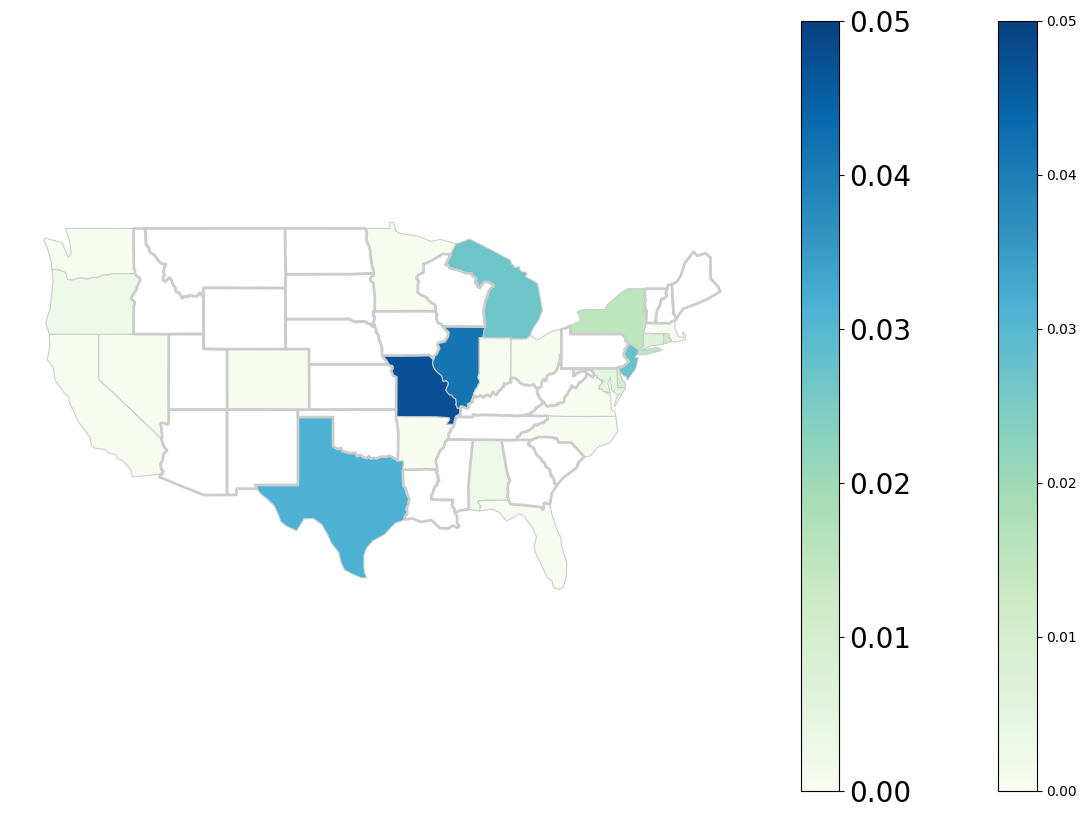

In [120]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define normalization to restrict the color range
norm = mcolors.Normalize(vmin=0, vmax=0.05)

# Plot the map without Hawaii and Alaska, applying the normalization
us_states_merged[us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'})].plot(
    column='patent_fraction_difference', cmap='GnBu', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8', norm=norm)

# Identify areas where 'patent_fraction_difference' is exactly zero
us_states_merged['patent_fraction_difference'] = us_states_merged['patent_fraction_difference'].apply(lambda x: 0 if x!=x else x)
zero_areas = us_states_merged[(us_states_merged['patent_fraction_difference'] == 0) & (us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'}))]

# Plot these areas with a distinct border color
zero_areas.plot(ax=ax, edgecolor='0.8', linewidth=2, facecolor='white')

# Add the color bar to the plot
cbar = plt.colorbar(ax.collections[0], ax=ax)

# Increase the tick label size for the color bar
cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set the title
# ax.set_title('Fraction of Consolidating Patent Distribution Compared to Null Model')
# plt.savefig('../../results/figures/Agglomeration_states_difference_consolidating.pdf')
plt.show()


In [121]:

us_states = gpd.read_file('../data/raw/naturalearth_lowers/')
geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'], disruptive_merged_df['latitude'])]
gdf_disruptive = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")

# Count patents per state
patent_counts_disruptive = gdf_disruptive['name'].value_counts().reset_index()
patent_counts_disruptive.columns = ['state', 'patent_count']

total_patents_disruptive = patent_counts_disruptive['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts_disruptive['patent_fraction'] = patent_counts_disruptive['patent_count'] / total_patents_disruptive


/tmp/ipykernel_12200/4233319538.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")


In [122]:
patent_counts_disruptive['patent_fraction_difference'] = patent_counts_disruptive.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
us_states_merged_disruptive = us_states.merge(patent_counts_disruptive, left_on='name', right_on='state', how='left')


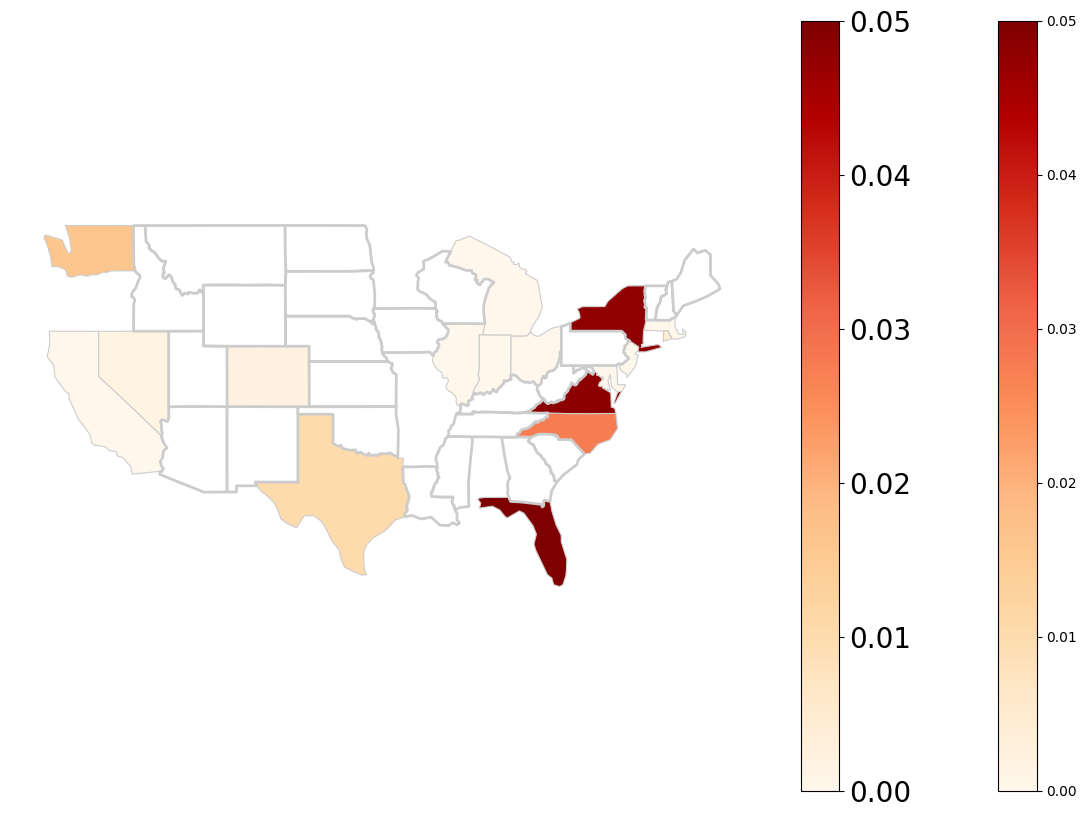

In [123]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define normalization to restrict the color range
norm = mcolors.Normalize(vmin=0, vmax=0.05)
# us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'})].plot(column='patent_fraction_difference', cmap='OrRd',legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')

# Plot the map without Hawaii and Alaska, applying the normalization
us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'})].plot(
    column='patent_fraction_difference', cmap='OrRd', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8', norm=norm)

# Identify areas where 'patent_fraction_difference' is exactly zero
us_states_merged['patent_fraction_difference'] = us_states_merged['patent_fraction_difference'].apply(lambda x: 0 if x!=x else x)
zero_areas = us_states_merged[(us_states_merged['patent_fraction_difference'] == 0) & (us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'}))]

# Plot these areas with a distinct border color
zero_areas.plot(ax=ax, edgecolor='0.8', linewidth=2, facecolor='white')

# Add the color bar to the plot
cbar = plt.colorbar(ax.collections[0], ax=ax)

# Increase the tick label size for the color bar
cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set the title
# ax.set_title('Fraction of Consolidating Patent Distribution Compared to Null Model')
# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptive.pdf')
plt.show()


In [125]:
disruptive_tasks['task_industry'] = disruptive_tasks['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)
consolidating_tasks['task_industry'] = consolidating_tasks['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)
tasks_exposedai['task_industry'] = tasks_exposedai['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)

/tmp/ipykernel_12200/1180987178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['task_industry'] = tasks_exposedai['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)


In [152]:
from collections import Counter

Counter(tasks_exposedai['task_industry'])

Counter({nan: 528,
         'Manufacturing': 411,
         'Health care and social assistance': 330,
         'Transportation and warehousing': 107,
         'Professional, Scientific and Technical Services': 100,
         'Public administration': 97,
         'Construction': 66,
         'Utilities': 47,
         'Retail trade': 46,
         'Education services': 44,
         'Other services, except public administration': 33,
         'Information': 29,
         'Agriculture, forestry, fishing and hunting': 26,
         'Arts, entertainment, and recreation': 21,
         'Accommodation and food services': 20,
         'Administrative and support and waste management and remediation services': 15,
         'Mining': 14,
         'Finance and insurance': 11,
         'Wholesale trade': 5})

In [165]:
def plot_by_sectors(type, industry):
    tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
    tasks_industry  = tasks_exposedai[tasks_exposedai['task_industry'].notna()]
    tasks_industry = tasks_industry [tasks_industry ['task_industry'].apply(lambda x: industry in x)]
    tasks_merge= pd.merge(tasks_industry,assignee_table, on ='patent_id',how='left' )
    tasks_merged_df = pd.merge(tasks_merge, location_table, on='location_id', how='left')

    geometry = [Point(xy) for xy in zip(tasks_merged_df['longitude'],tasks_merged_df['latitude'])]
    gdf = gpd.GeoDataFrame(tasks_merged_df, geometry=geometry)
    
    # Spatial join points to the US states
    
    gdf = gpd.sjoin(gdf, us_states, how="inner")
    # Count patents per state
    patent_counts = gdf['name'].value_counts().reset_index()
    patent_counts.columns = ['state', 'patent_count']
    total_patents = patent_counts['patent_count'].sum()
    
    # Convert counts to fractions of the total
    patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents

    state_fraction_dict = patent_counts.set_index('state')['patent_fraction'].to_dict()
    
    # Output the dictionary to verify
 

    if type == 'consolidating':
        consolidating_tasks['patent_id'] = consolidating_tasks['patent_id'].astype(str)
        consolidating_tasks_industry = consolidating_tasks[consolidating_tasks['task_industry'].notna()]
        consolidating_tasks_industry = consolidating_tasks_industry[consolidating_tasks_industry['task_industry'].apply(lambda x: industry in x)]
        consolidating_merge= pd.merge(consolidating_tasks_industry,assignee_table, on ='patent_id',how='left' )
        consolidating_merged_df = pd.merge(consolidating_merge, location_table, on='location_id', how='left')

        geometry = [Point(xy) for xy in zip(consolidating_merged_df['longitude'],consolidating_merged_df['latitude'])]
        gdf = gpd.GeoDataFrame(consolidating_merged_df, geometry=geometry)
    if type == 'disruptive':
        disruptive_tasks['patent_id'] = disruptive_tasks['patent_id'].astype(str)
        disruptive_tasks_industry = disruptive_tasks[disruptive_tasks['task_industry'].notna()]
        disruptive_tasks_industry = disruptive_tasks_industry[disruptive_tasks_industry['task_industry'].apply(lambda x: industry in x)]
        disruptive_merge= pd.merge(disruptive_tasks_industry,assignee_table, on ='patent_id',how='left' )
        disruptive_merged_df = pd.merge(disruptive_merge, location_table, on='location_id', how='left')

        geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'],disruptive_merged_df['latitude'])]
        gdf = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

    
    # Spatial join points to the US states
    gdf = gpd.sjoin(gdf, us_states, how="inner")
    # Count patents per state
    patent_counts = gdf['name'].value_counts().reset_index()
    patent_counts.columns = ['state', 'patent_count']
    
    total_patents = patent_counts['patent_count'].sum()
    
    # Convert counts to fractions of the total
    patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    patent_counts['patent_fraction_difference'] = patent_counts.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
    us_states_merged = us_states.merge(patent_counts, left_on='name', right_on='state', how='left')
    
    norm = mcolors.Normalize(vmin=0, vmax=0.455)
    if type == 'consolidating':
        us_states_merged.plot(column='patent_fraction_difference', cmap='GnBu', linewidth=0.8, ax=ax, edgecolor='0.8',norm=norm)
    elif type == 'disruptive':
        us_states_merged.plot(column='patent_fraction_difference', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8',norm=norm)
    
    ax.set_title('Gini Coefficient of Patent Distribution by US State')
    
    # Identify areas where 'patent_fraction_difference' is exactly zero
    us_states_merged['patent_fraction_difference'] = us_states_merged['patent_fraction_difference'].apply(lambda x: 0 if x!=x else x)
    print(max(us_states_merged['patent_fraction_difference']))
    zero_areas = us_states_merged[(us_states_merged['patent_fraction_difference'] == 0) & (us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'}))]
    
    
    # Plot these areas with a distinct border color
    zero_areas.plot(ax=ax, edgecolor='0.8', linewidth=2, facecolor='none')

    # Add the color bar to the plot
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    
    # Increase the tick label size for the color bar
    # cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed
    # cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
    cbar.set_ticks([0, 0.05, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4,0.45])  # Define specific tick values
    cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

    
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_title(type+"_"+industry)
    plt.savefig("../results/figures/agglomeration"+type+"_"+industry+".pdf")
    plt.show()




    
        
        



/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.08923141449093007


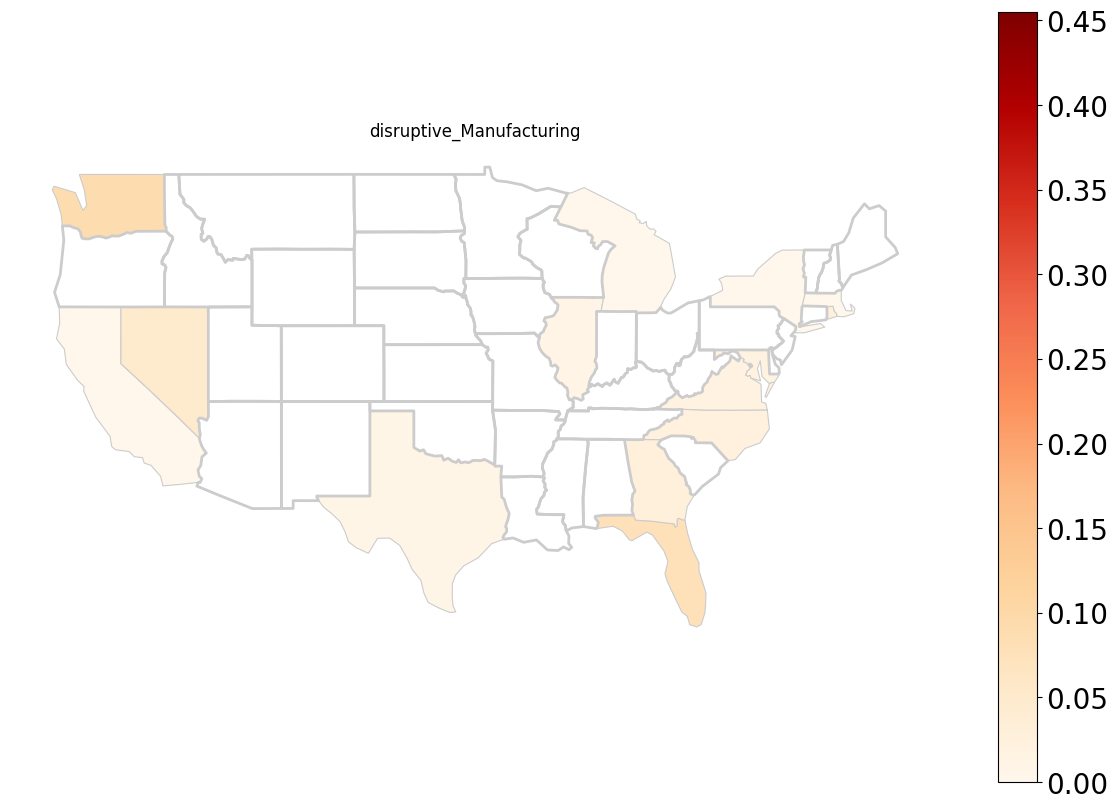

In [166]:
plot_by_sectors("disruptive", "Manufacturing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.10944244283522991


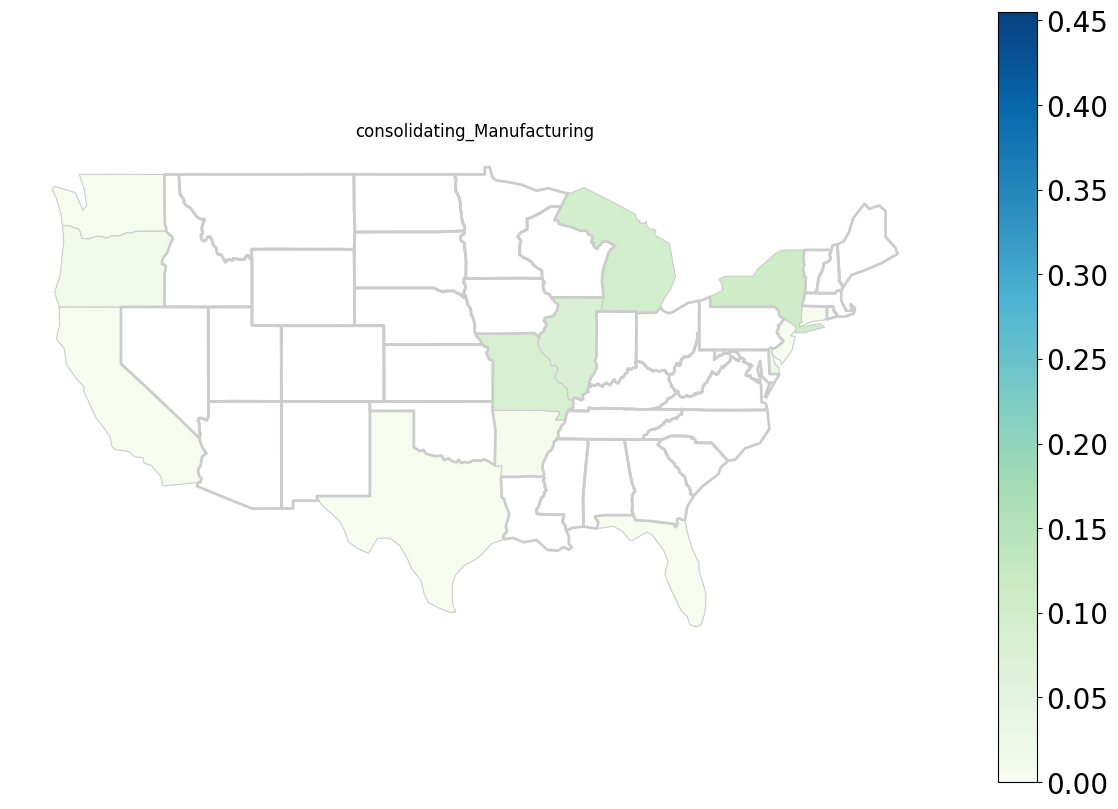

In [167]:
plot_by_sectors("consolidating", "Manufacturing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.12572798903734156


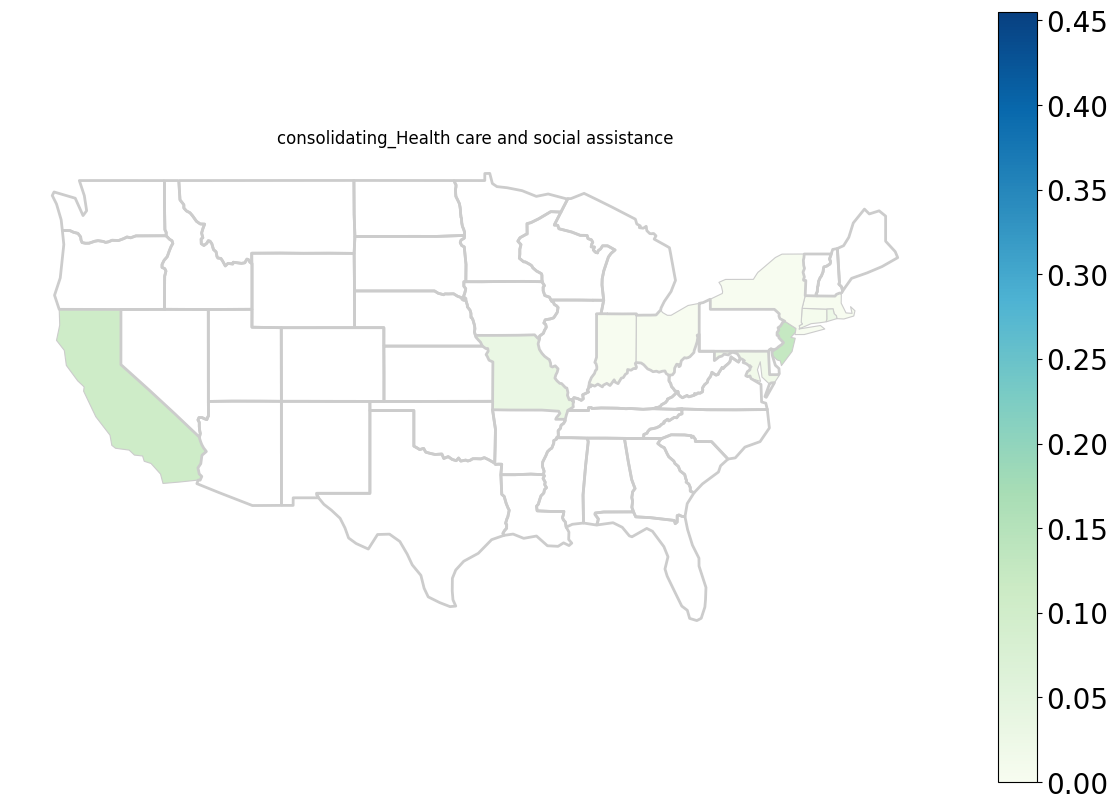

In [168]:
plot_by_sectors("consolidating", "Health care and social assistance")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.4540938677629326


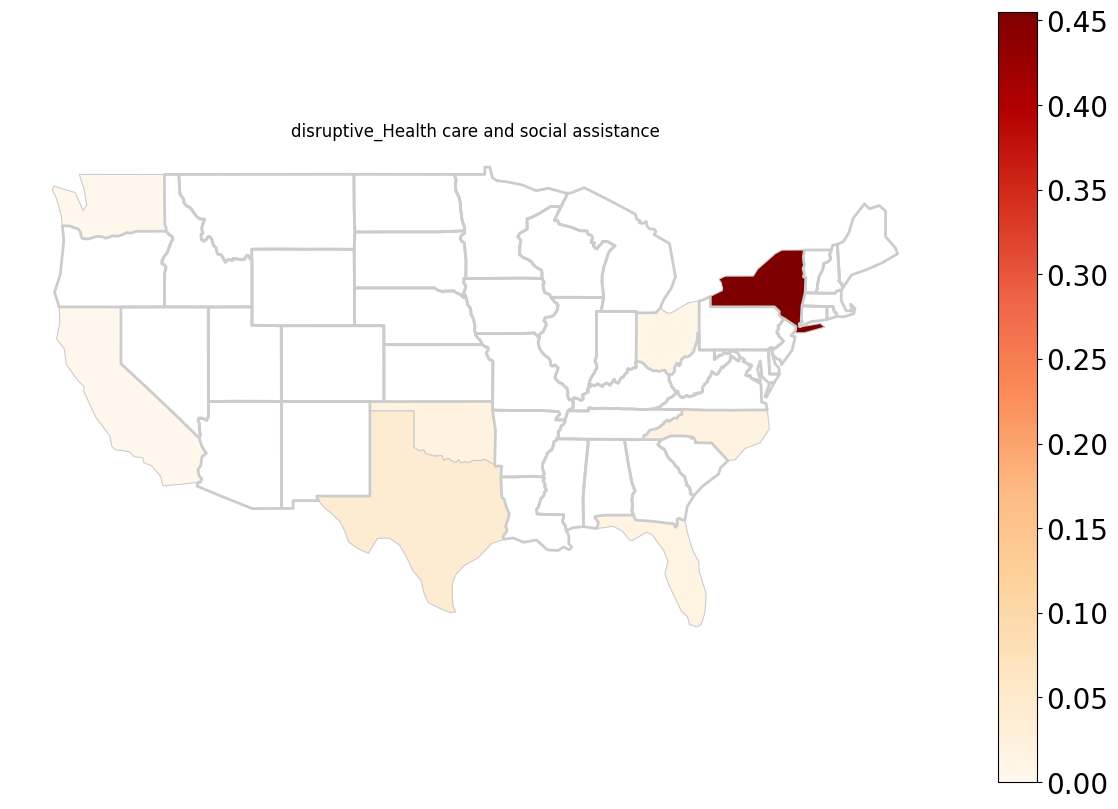

In [169]:
plot_by_sectors("disruptive", "Health care and social assistance")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.21118012422360247


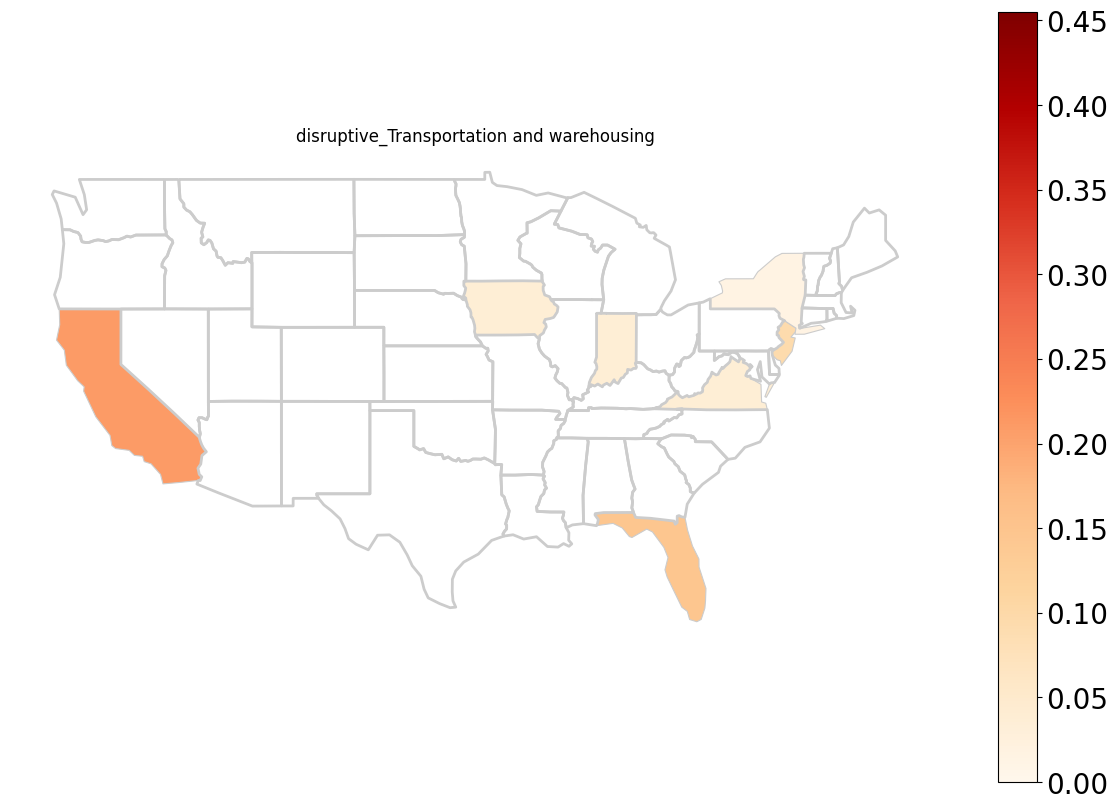

In [170]:
plot_by_sectors("disruptive", "Transportation and warehousing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.2717391304347826


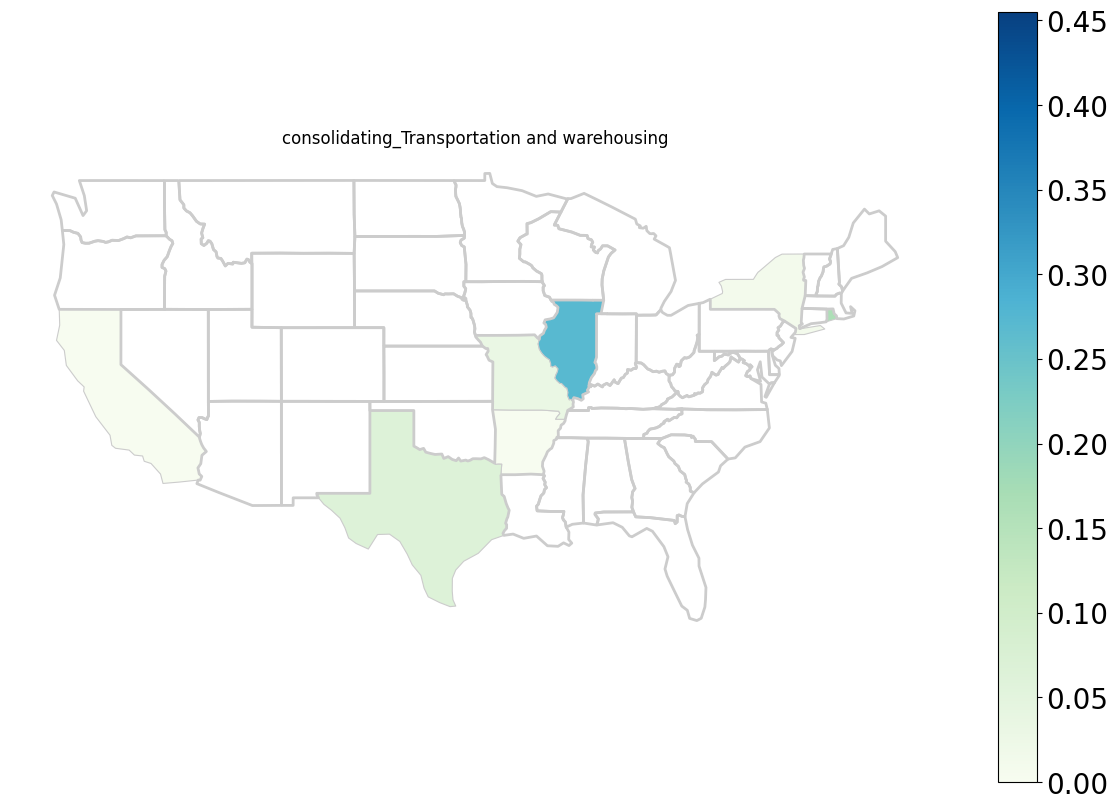

In [171]:
plot_by_sectors("consolidating", "Transportation and warehousing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.12008978675645343


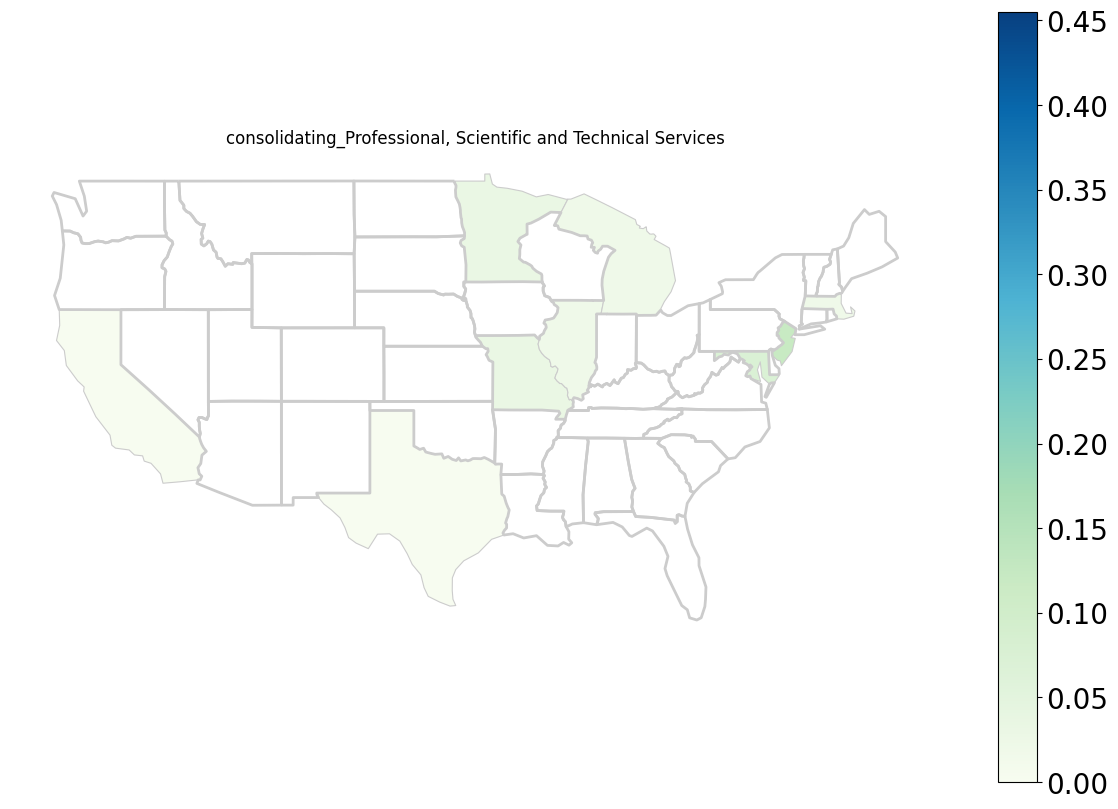

In [172]:
plot_by_sectors("consolidating", "Professional, Scientific and Technical Services")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.17356572258533043


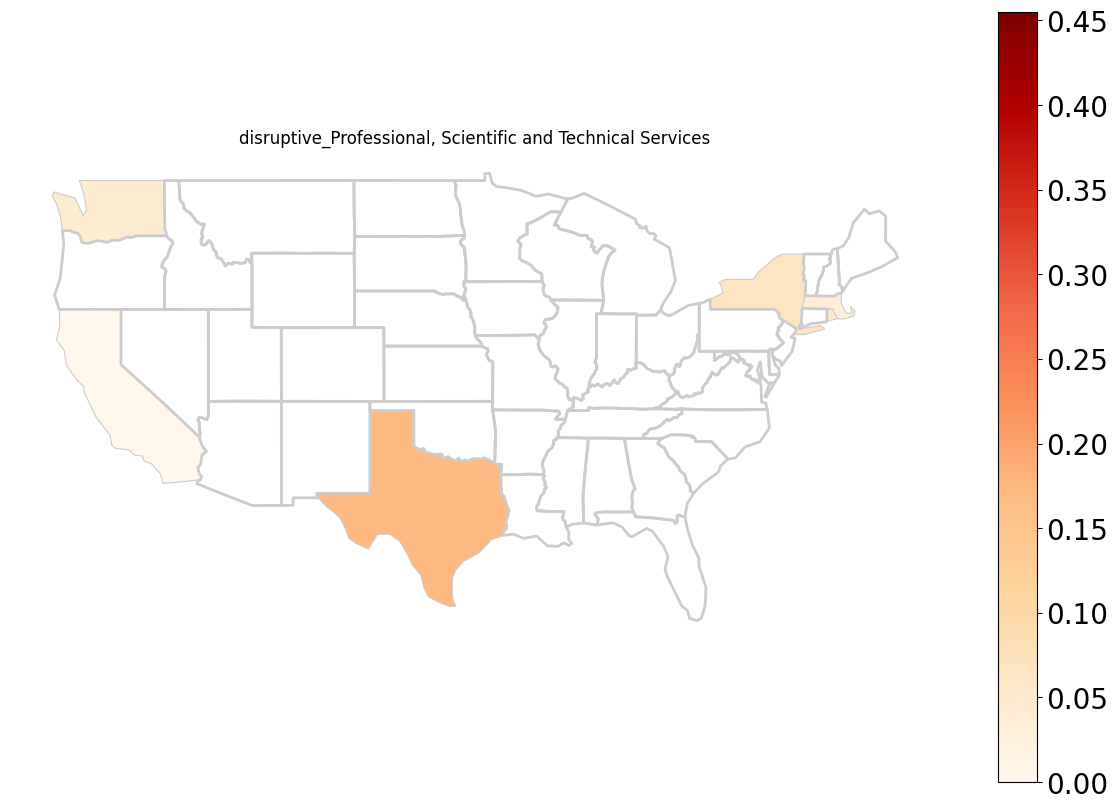

In [173]:
plot_by_sectors("disruptive", "Professional, Scientific and Technical Services")